# Import

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from datetime import datetime, timedelta

import torch

import warnings
warnings.filterwarnings('ignore')

In [82]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_THREADS = 10
N_FOLDS = 5
TIMEOUT = 600

In [4]:
np.random.seed(RANDOM_STATE)

# 1. Чтение и скачивание данных

Необходимо построить модель, которая будет предсказывать общую продолжительность поездок на такси в Нью-Йорке. Данные включают информацию о времени доставки, геграфических координатах, количествах пассажиров и т.д. 

In [5]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

weather = pd.read_csv('data/weather.csv')

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before 

sending to the vendor because the vehicle did not have a connection to the server - Y=store and 

forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds


Информация о маршрутах из osrm

In [6]:
routes_1 = pd.read_csv('data/fastest_routes_train_part_1.csv')
routes_2 = pd.read_csv('data/fastest_routes_train_part_2.csv')

In [7]:
weather[:3]

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0


In [8]:
test[:3]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N


In [9]:
df[:3]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [11]:
routes_1[:3]

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."


# 2. EDA

## 2.1 Анализ маршрутов train/test

(40.5, 41.0)

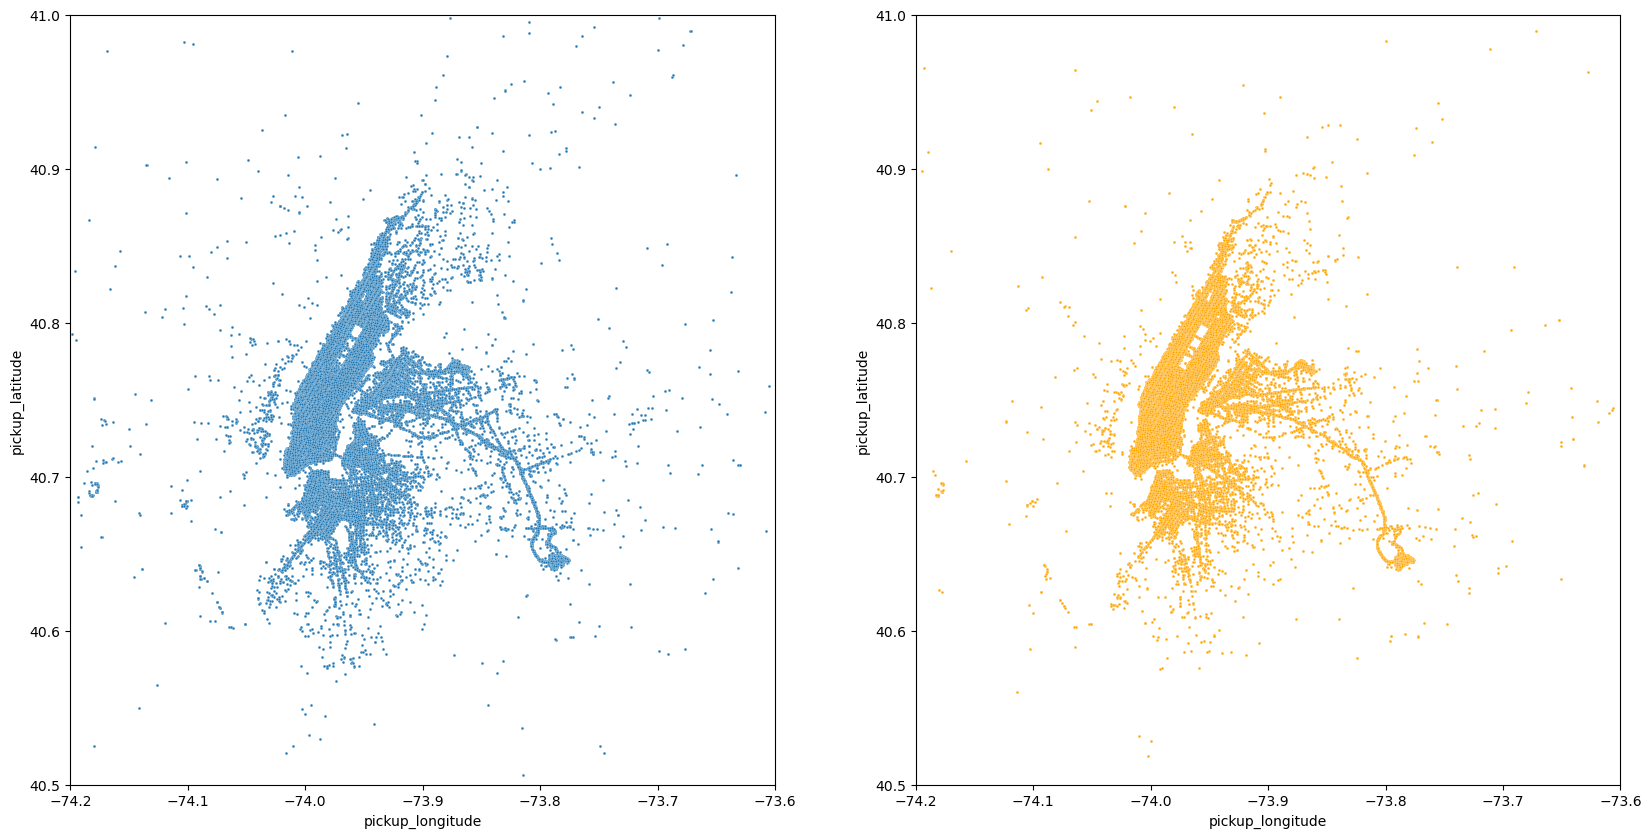

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.scatterplot(df['pickup_longitude'], df['pickup_latitude'], s=4, ax=ax[0])
ax[0].set_xlim([-74.2, -73.6])
ax[0].set_ylim([40.5, 41.0])

sns.scatterplot(test['pickup_longitude'], test['pickup_latitude'], s=4, ax=ax[1], color='orange')
ax[1].set_xlim([-74.2, -73.6])
ax[1].set_ylim([40.5, 41.0])

In [13]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000,1458644.00000
mean,1.53495,1.66453,-73.97349,40.75092,-73.97342,40.75180,959.49227
std,0.49878,1.31424,0.07090,0.03288,0.07064,0.03589,5237.43172
min,1.00000,0.00000,-121.93334,34.35970,-121.93330,32.18114,1.00000
25%,1.00000,1.00000,-73.99187,40.73735,-73.99133,40.73588,397.00000
50%,2.00000,1.00000,-73.98174,40.75410,-73.97975,40.75452,662.00000
75%,2.00000,2.00000,-73.96733,40.76836,-73.96301,40.76981,1075.00000
max,2.00000,9.00000,-61.33553,51.88108,-61.33553,43.92103,3526282.00000


In [14]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.00000,625134.00000,625134.00000,625134.00000,625134.00000,625134.00000
mean,1.53488,1.66177,-73.97361,40.75093,-73.97346,40.75182
std,0.49878,1.31129,0.07339,0.02985,0.07256,0.03582
min,1.00000,0.00000,-121.93313,37.38959,-121.93333,36.60132
25%,1.00000,1.00000,-73.99185,40.73739,-73.99132,40.73600
50%,2.00000,1.00000,-73.98174,40.75409,-73.97977,40.75454
75%,2.00000,2.00000,-73.96740,40.76839,-73.96301,40.76985
max,2.00000,9.00000,-69.24892,42.81494,-67.49680,48.85760


Обратим внимание в особенности на max и min значения, где-то trip_duration = 1 min, количество пассажиров где-то 0, максимально 9, скорее всего это могут быть ошибки в данных. Также обратим внимание на долготу и широту, так как нам необходим только город New York, то тогда нужно ограничить пределы по долготе и широте (используем карты)

In [15]:
df[df.pickup_longitude < -75]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.45592,39.80393,-73.79602,40.70773,N,23440
193116,id2769862,1,2016-02-06 15:43:15,2016-02-06 15:50:12,1,-77.89602,37.77777,-77.89602,37.77777,N,417
233451,id1703300,2,2016-04-26 16:46:00,2016-04-26 16:47:00,1,-77.03944,38.89885,-77.03944,38.89885,N,60
235449,id2298947,2,2016-04-14 15:53:00,2016-04-14 15:54:00,1,-77.03944,38.89885,-77.03944,38.89885,N,60
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.35433,34.71223,-73.83492,32.18114,N,875
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.54740,40.81713,-79.78613,40.91764,N,279
646333,id2209294,1,2016-05-22 16:50:00,2016-05-22 16:52:54,1,-75.52462,39.44115,-75.52462,39.44115,N,174
656806,id2344725,2,2016-02-12 12:51:26,2016-02-12 13:02:50,1,-75.24149,41.43066,-75.57015,41.20148,N,684
801241,id3301642,2,2016-05-19 12:53:00,2016-05-19 12:54:00,1,-77.03944,38.89885,-77.03944,38.89885,N,60
952661,id0784573,1,2016-03-28 17:55:13,2016-03-28 18:08:15,2,-77.44075,36.02930,-77.44075,36.02930,N,782


In [16]:
df = df[df.pickup_longitude.between(-75, -71) & df.dropoff_longitude.between(-75, -71)]

In [17]:
test[test.pickup_longitude < -75]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
152325,id0159022,2,2016-05-16 13:37:00,1,-77.03944,38.89885,-77.03944,38.89885,N
203685,id1455078,2,2016-05-02 09:57:00,1,-77.03944,38.89885,-77.03944,38.89885,N
262912,id1357179,2,2016-04-15 11:47:00,1,-77.03944,38.89885,-77.03944,38.89885,N
308069,id3858705,1,2016-04-02 22:42:19,1,-76.96324,38.94603,-76.96324,38.94603,N
324125,id0505885,2,2016-03-29 14:28:46,2,-121.93313,37.38959,-121.93333,37.38937,N
336944,id1304703,2,2016-03-25 17:21:00,3,-76.99153,38.86469,-76.99153,38.86469,N
344754,id3395374,2,2016-03-23 13:46:00,1,-76.99153,38.86469,-76.99153,38.86469,N
380737,id3233992,1,2016-03-13 04:20:44,3,-79.48790,40.73916,-79.48790,40.73916,N
483163,id1850697,1,2016-02-13 16:37:27,1,-77.59821,42.81494,-77.59821,42.81494,N


## 2.2 Feature engineering

Найдем для начала расстояние в метрах haversine (от точки до точки по прямой с учетом формы Земли)

In [18]:
# Параллельные вычисления
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [19]:
def haversine(data):
    from math import  radians, cos, sin, asin, sqrt
    """
    Вычисление расстояния в километрах между двумя точками на Земле
    """
    lon_1 = data['pickup_longitude'] 
    lat_1 = data['pickup_latitude']
    lon_2 = data['dropoff_longitude']
    lat_2 = data['dropoff_latitude']
    
    lon_1, lat_1, lon_2, lat_2 = map(radians, [lon_1, lat_1, lon_2, lat_2])
    dlon = lon_2 - lon_1
    dlat = lat_2 - lat_1
    
    a = sin(dlat/2)**2 + cos(lat_1) * cos(lat_2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    r = 6371
    return c * r

In [20]:
df['distance_geo'] = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 
                         'dropoff_latitude']].parallel_apply(haversine, axis=1)

In [21]:
df[:2]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455,1.49852
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663,1.80551


In [22]:
weather.describe(include='object')

,date,precipitation,snow fall,snow depth
count,366,366,366,366
unique,366,63,11,10
top,1-1-2016,0,0,0
freq,1,116,179,346


In [23]:
weather.precipitation.unique()

array(['0.00', 'T', '1.80', '0.24', '0.05', '0.01', '2.31', '0.73',
       '0.53', '0.44', '1.01', '0.03', '0.30', '1.22', '0.02', '0.14',
       '0.11', '0.06', '0.29', '0.07', '0.04', '0.38', '0.16', '0.09',
       '0.47', '0.20', '0.61', '0.54', '0.25', '0.18', '1.65', '0.40',
       '0.91', '0.45', '0.22', '0.12', '0.83', '0', '0.49', '0.66',
       '0.08', '0.62', '0.35', '1', '1.09', '1.08', '0.15', '0.32',
       '0.82', '0.31', '0.5', '0.56', '0.68', '0.2', '0.4', '0.23',
       '0.55', '1.11', '1.41', '1.81', '2.2', '0.19', '0.39'],
      dtype=object)

In [24]:
weather.loc[weather['precipitation'] == 'T', 'precipitation'] = '0.00'
weather['precipitation'] = weather['precipitation'].astype(float)

weather.loc[weather['snow fall'] == 'T', 'snow fall'] = '0.00'
weather['snow fall'] = weather['snow fall'].astype(float)

weather.loc[weather['snow depth'] == 'T', 'snow depth'] = '0.00'
weather['snow depth'] = weather['snow depth'].astype(float)

Добавим погодные условия

In [25]:
df['date'] = df.pickup_datetime.apply(lambda x: datetime.strptime(x[:10], '%Y-%m-%d'))
weather['date'] = weather.date.apply(lambda x: datetime.strptime(x[:10], '%d-%m-%Y'))

df_all = pd.merge(df, weather, how='left', on='date')
df_all[:5]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_geo,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,N,455,1.49852,2016-03-14,51,40,45.50000,0.29000,0.00000,0.00000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,N,663,1.80551,2016-06-12,83,62,72.50000,0.00000,0.00000,0.00000
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.97903,40.76394,-74.00533,40.71009,N,2124,6.38510,2016-01-19,28,16,22.00000,0.00000,0.00000,0.00000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.71997,-74.01227,40.70672,N,429,1.48550,2016-04-06,48,30,39.00000,0.00000,0.00000,0.00000
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97305,40.79321,-73.97292,40.78252,N,435,1.18859,2016-03-26,55,38,46.50000,0.00000,0.00000,0.00000


In [26]:
df_all.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
dropoff_datetime       0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
trip_duration          0
distance_geo           0
date                   0
maximum temperature    0
minimum temperature    0
average temperature    0
precipitation          0
snow fall              0
snow depth             0
dtype: int64

Преобразуем время в новые признаки, которые удобно будет исследовать в дальнейшем

In [27]:
df_all['pickup_datetime'] = pd.to_datetime(df_all['pickup_datetime'])

df_all['pickup_month'] = df_all['pickup_datetime'].apply(lambda x: x.month)
df_all['pickup_day'] = df_all['pickup_datetime'].apply(lambda x: x.day)
df_all['pickup_dayofweek'] = df_all['pickup_datetime'].apply(lambda x: x.dayofweek)
df_all['pickup_hour'] = df_all['pickup_datetime'].apply(lambda x: x.hour)
df_all['pickup_minute'] = df_all['pickup_datetime'].apply(lambda x: x.minute)
df_all['pickup_weekends'] = df_all['pickup_dayofweek'].apply(lambda x: 1 if x >=5 else 0)

df_all['store_and_fwd_flag'] = 1 * (df_all.store_and_fwd_flag == 'Y')

In [28]:
df_all.reset_index(drop=True, inplace=True)

In [29]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

df_all['pickup_holiday'] = df_all['date'].isin(holidays)
df_all['pickup_holiday'] = df_all['pickup_holiday'].map(lambda x: 1 if x == True else 0)

df_all['pickup_near_holiday'] = df_all['date'].isin(holidays + timedelta(
    days=1)) | df_all['date'].isin(holidays - timedelta(days=1))
df_all['pickup_near_holiday'] = df_all['pickup_near_holiday'].map(lambda x: 1 if x==True else 0)

Добавим информацию о расстоянии маршрута с учетом дорог

In [30]:
routes = routes_1.append(routes_2)
df_all = pd.merge(df_all, routes[['id', 'total_distance']], on='id', how='left')

In [31]:
test['distance_geo'] = test[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                            'dropoff_latitude']].parallel_apply(haversine, axis=1)

Теперь посмотрим на распределение времени поездки

In [32]:
df_all.trip_duration.describe()

count   1458612.00000
mean        959.46376
std        5237.43217
min           1.00000
25%         397.00000
50%         662.00000
75%        1075.00000
max     3526282.00000
Name: trip_duration, dtype: float64

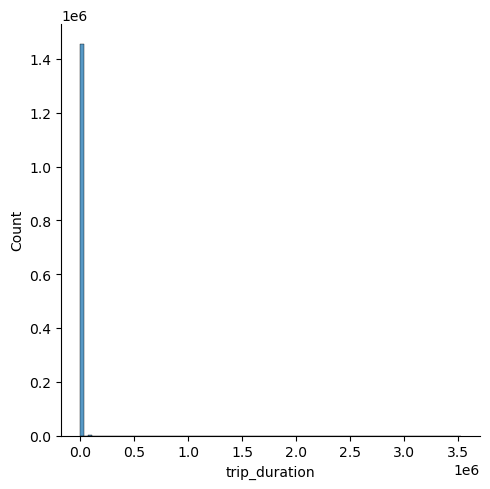

In [33]:
sns.displot(df_all.trip_duration, bins=100)

Видно, что есть выбросы, прологорифмуем целевую переменную и добавлю значения в датасет

In [34]:
df_all = df_all.assign(log_trip_duration = np.log(df_all.trip_duration + 1))

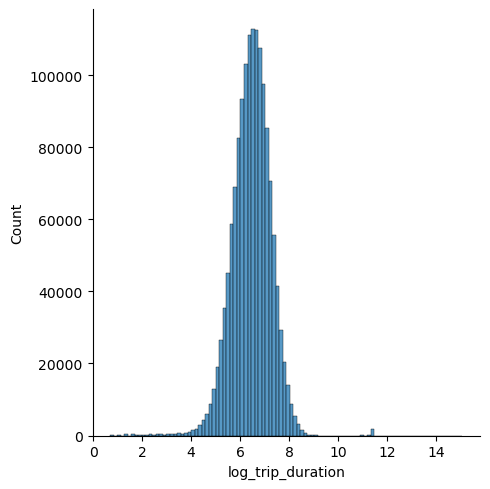

In [35]:
sns.displot(df_all.log_trip_duration, bins=100)

In [36]:
df_all['trip_duration_hour'] = df_all['trip_duration'] / 3600
df_all['total_distance_km'] = df_all['total_distance'] / 1000

df_all['speed_km_h'] = df_all['total_distance_km'] / df_all['trip_duration_hour']

In [37]:
df_all['speed_km_h'].describe()

count   1458611.00000
mean         19.47983
std          25.23001
min           0.00000
25%          12.40946
50%          17.10889
75%          23.50359
max       12428.38286
Name: speed_km_h, dtype: float64

Видим явные выбросы

## 2.3 Обработка выбросов

In [38]:
df_all = df_all[~df_all.passenger_count.isin([0, 7, 8, 9])]
df_all = df_all[df_all['speed_km_h'] != 0]

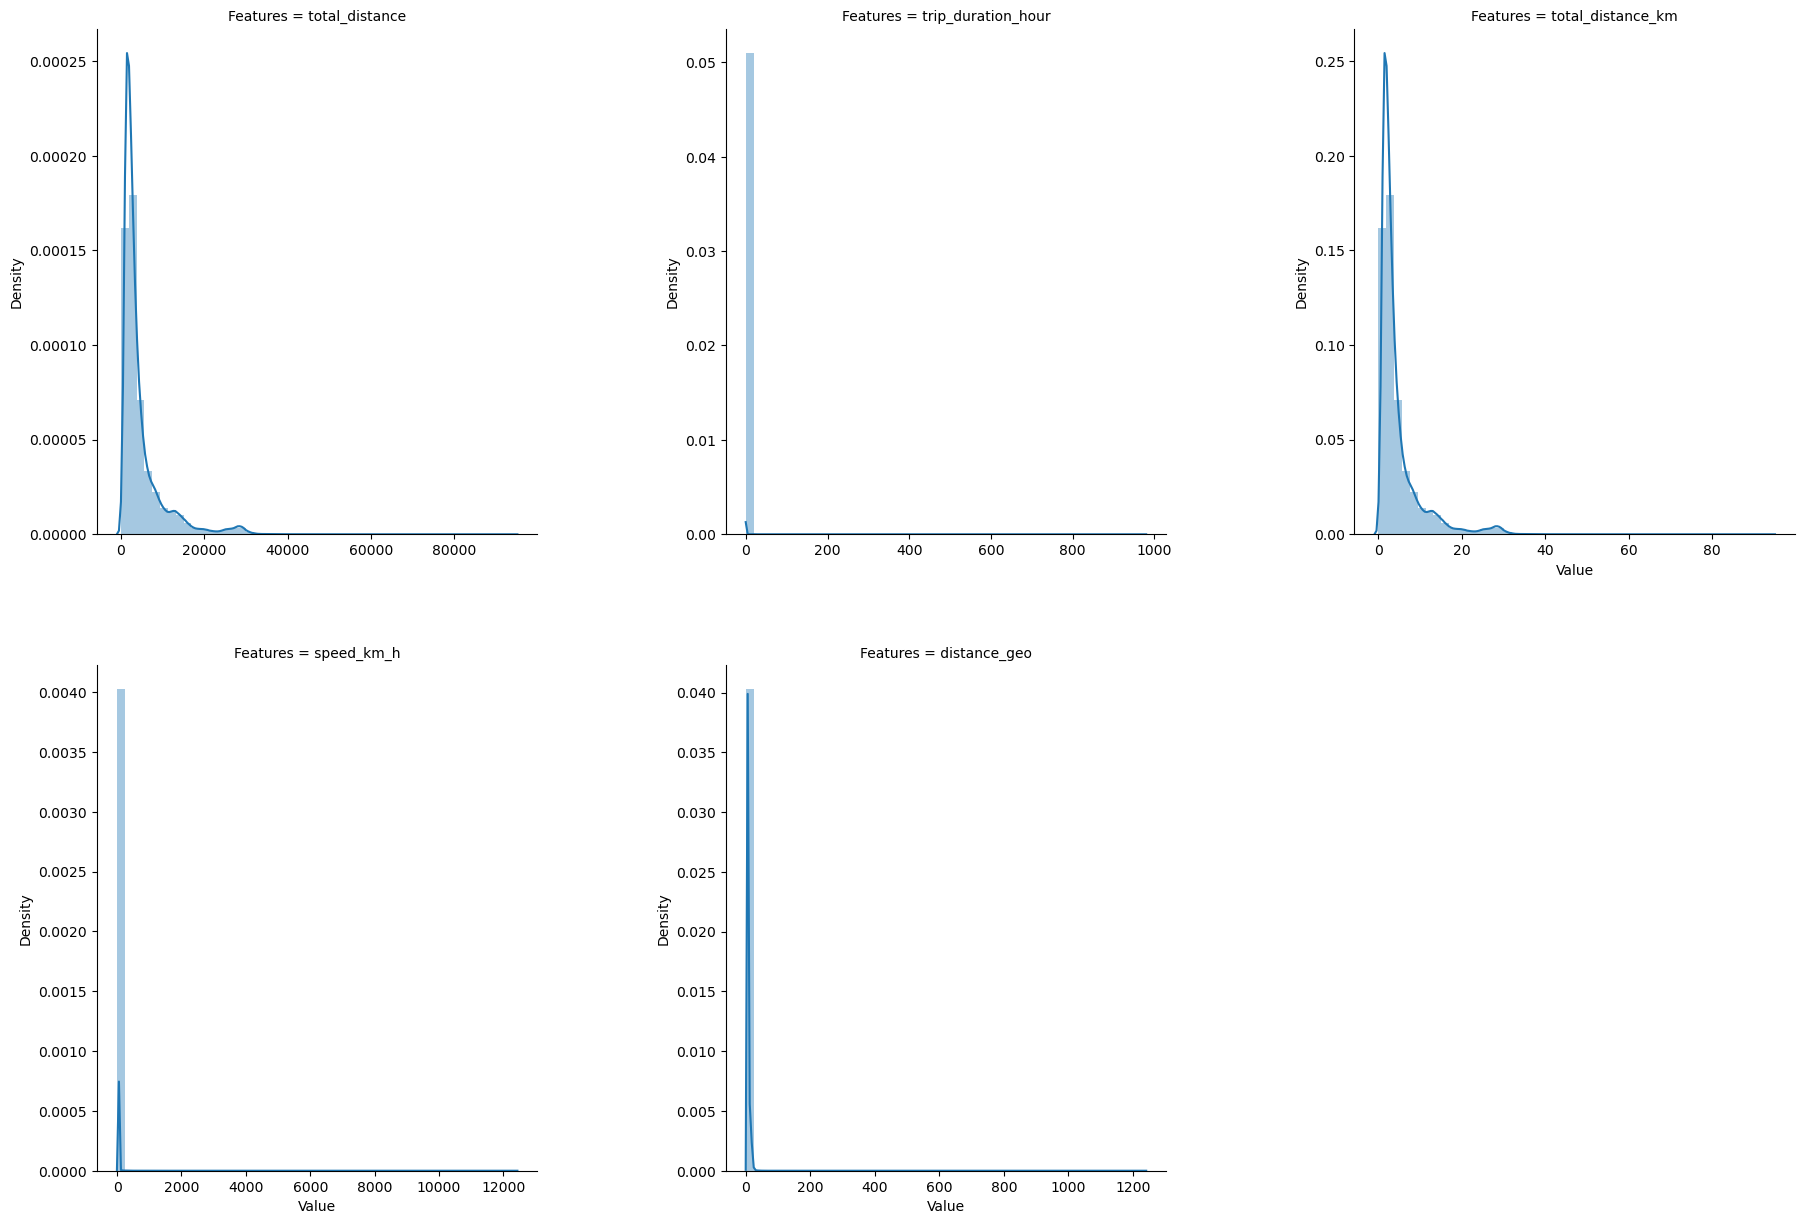

In [39]:
num_cols = ['total_distance', 'trip_duration_hour', 'total_distance_km', 'speed_km_h', 'distance_geo']

numeric_features = df_all[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={'level_1': 'Features', 0: 'Value'})

ax = sns.FacetGrid(data=numeric_features, col='Features',
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=2, right=2)

In [40]:
for i in num_cols:
    df_all['log_' + i] = np.log(df_all[i] + 1)

In [41]:
df_all[:2]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_distance,log_trip_duration,trip_duration_hour,total_distance_km,speed_km_h,log_total_distance,log_trip_duration_hour,log_total_distance_km,log_speed_km_h,log_distance_geo
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98215,40.76794,-73.96463,40.76560,0,...,2009.10000,6.12249,0.12639,2.00910,15.89618,7.60594,0.11902,1.10164,2.82709,0.91570
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98042,40.73856,-73.99948,40.73115,0,...,2513.20000,6.49828,0.18417,2.51320,13.64633,7.82971,0.16904,1.25653,2.68419,1.03158


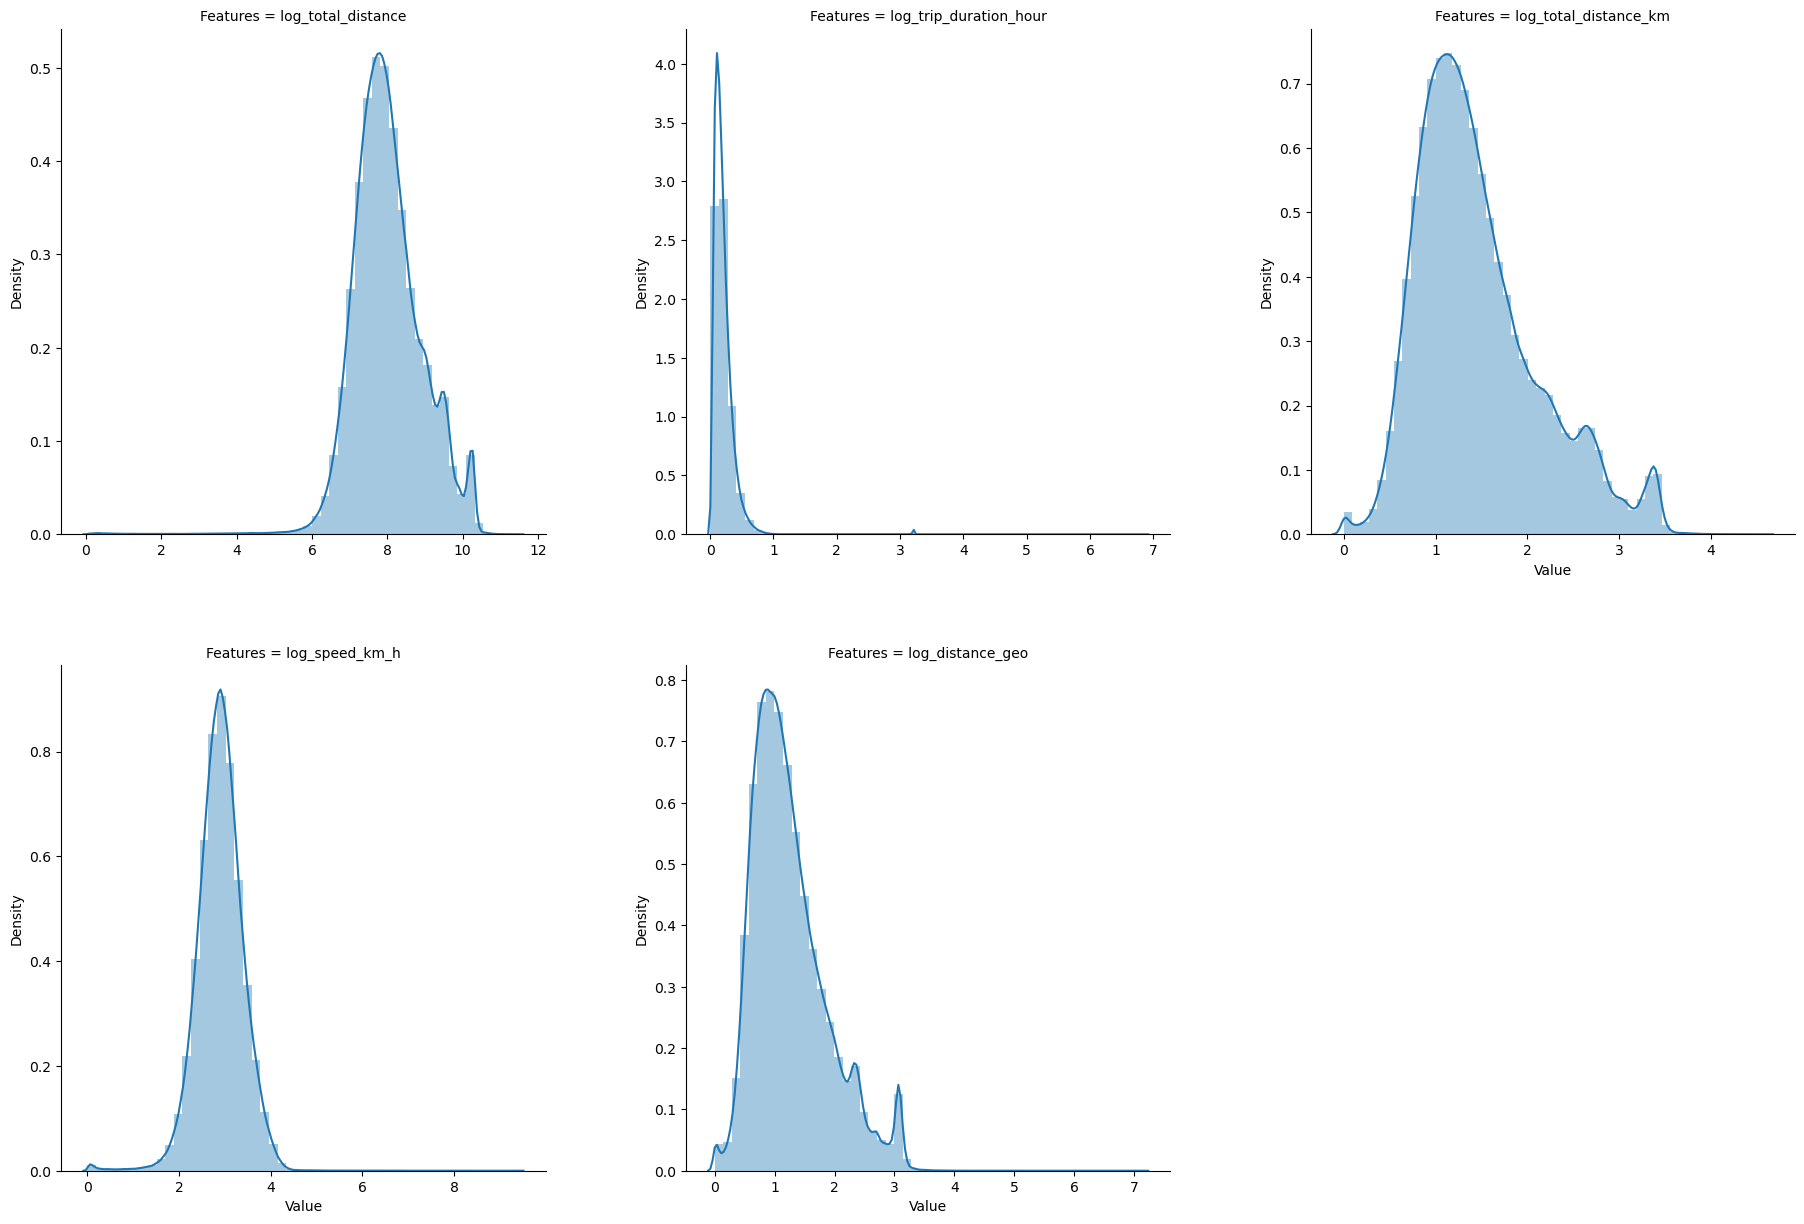

In [42]:
num_cols = ['log_total_distance', 'log_trip_duration_hour', 'log_total_distance_km', 
            'log_speed_km_h', 'log_distance_geo']

numeric_features = df_all[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={'level_1': 'Features', 0: 'Value'})

ax = sns.FacetGrid(data=numeric_features, col='Features',
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, 'Value')

plt.subplots_adjust(top=2, right=2)

В следующем графике проанализируем процент количества пассажиров в будгие и выходные дни по времени.
Будние дни отмечены синим цветом. В будние дни количество пассажиров увеличивается с 6 до 9 утра, также после рабочего времени с 6. 

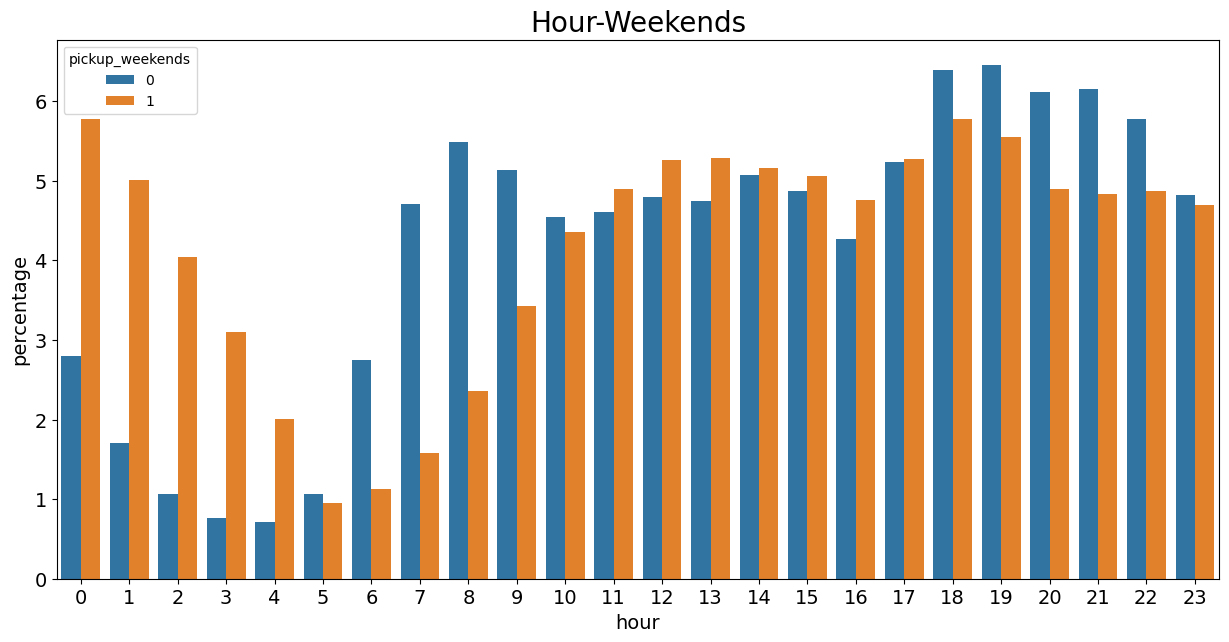

In [43]:
norm_house = (df_all.groupby(['pickup_weekends'])['pickup_hour']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

plt.figure(figsize=(15, 7))
ax=sns.barplot(x='pickup_hour', y='percentage', hue='pickup_weekends', data=norm_house)

plt.title('Hour-Weekends', fontsize=20)
plt.ylabel('percentage', fontsize=14)
plt.xlabel('hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);              

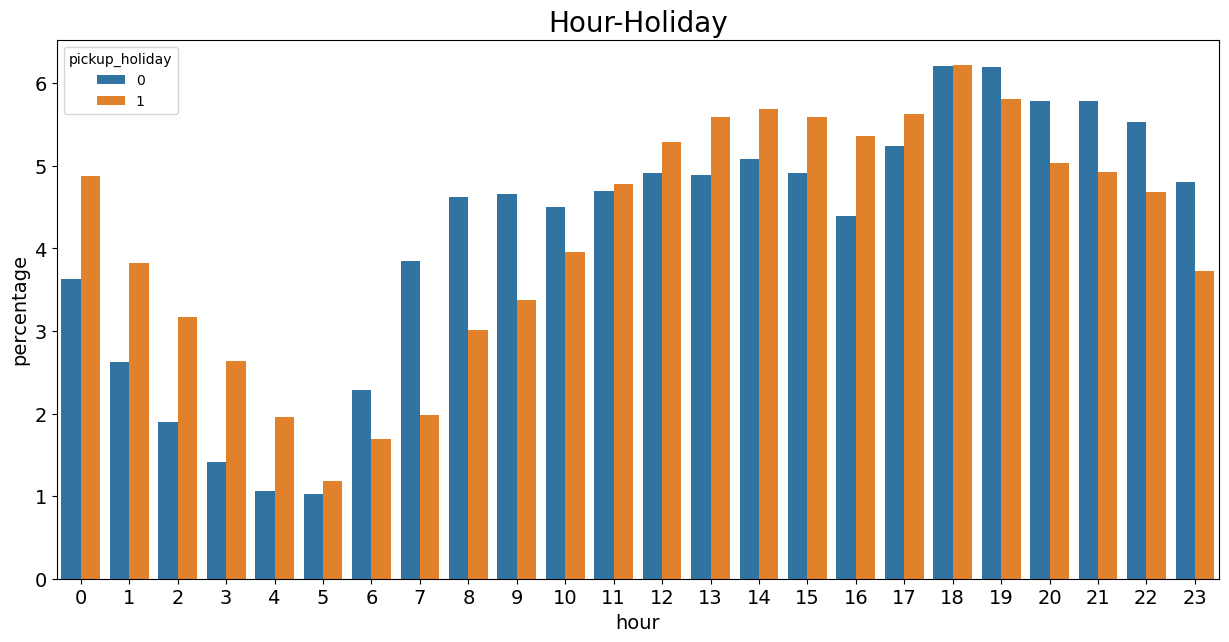

In [44]:
norm_house = (df_all.groupby(['pickup_holiday'])['pickup_hour']
              .value_counts(normalize=True)
              .rename('percentage')
              .mul(100)
              .reset_index()
              .sort_values('pickup_hour'))

plt.figure(figsize=(15, 7))
ax=sns.barplot(x='pickup_hour', y='percentage', hue='pickup_holiday', data=norm_house)

plt.title('Hour-Holiday', fontsize=20)
plt.ylabel('percentage', fontsize=14)
plt.xlabel('hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);  

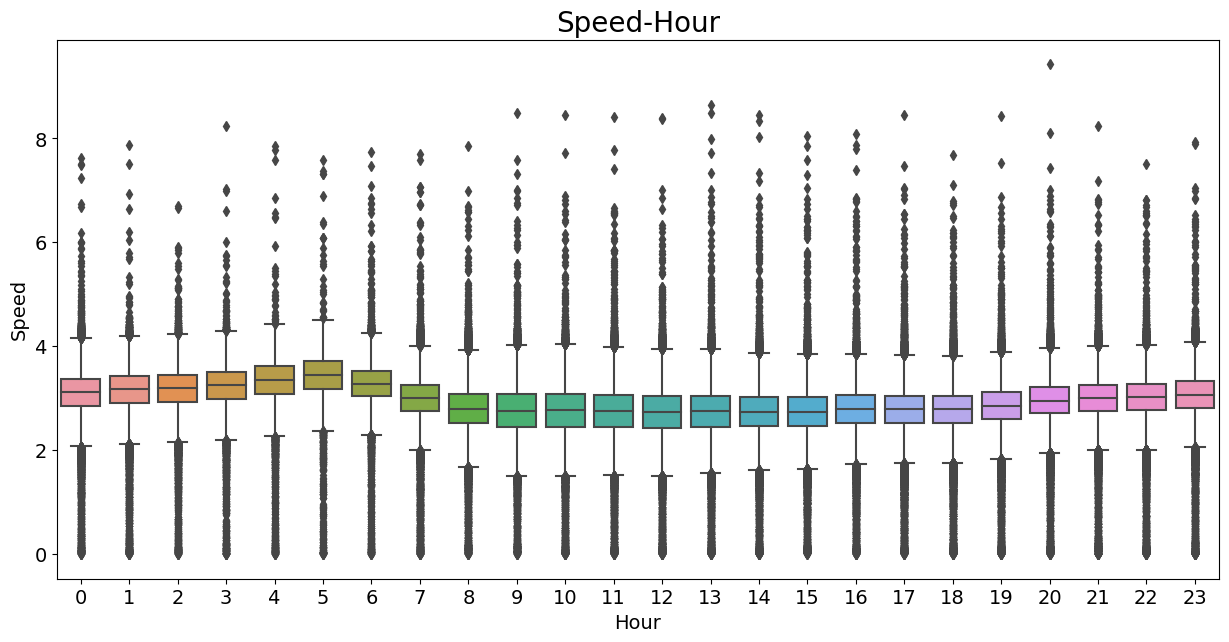

In [45]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_speed_km_h', data=df_all)

plt.title('Speed-Hour', fontsize=20)
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14); 

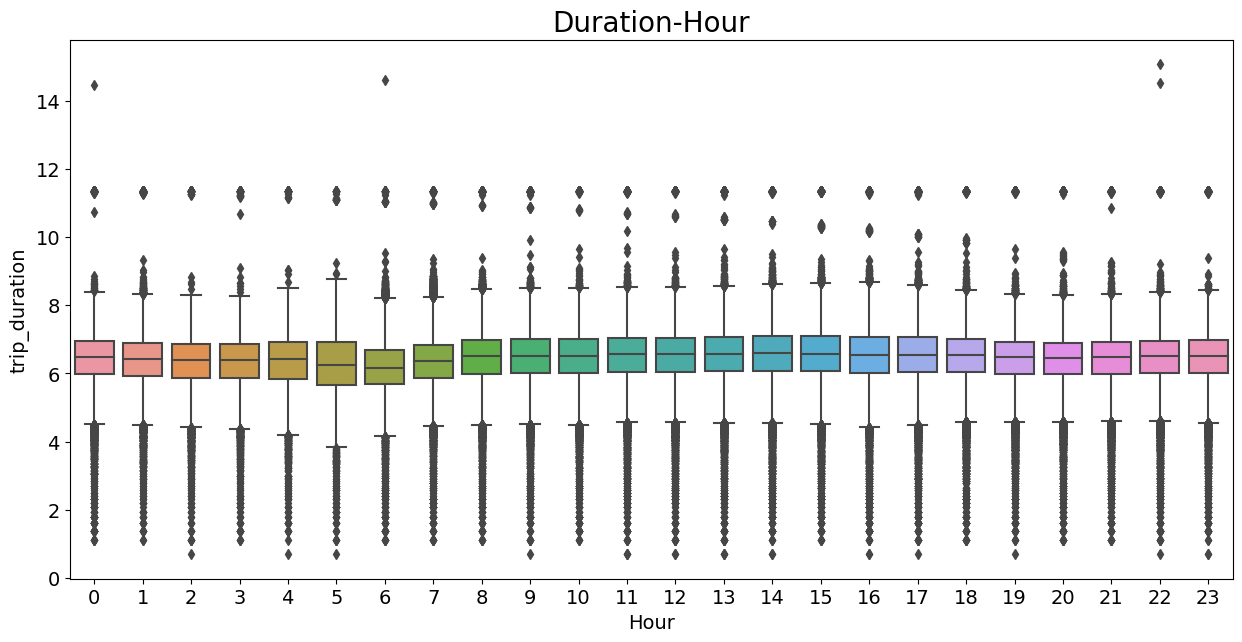

In [46]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='pickup_hour', y='log_trip_duration', data=df_all)

plt.title('Duration-Hour', fontsize=20)
plt.ylabel('trip_duration', fontsize=14)
plt.xlabel('Hour', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14); 

Коррелирующий параметр

<AxesSubplot:>

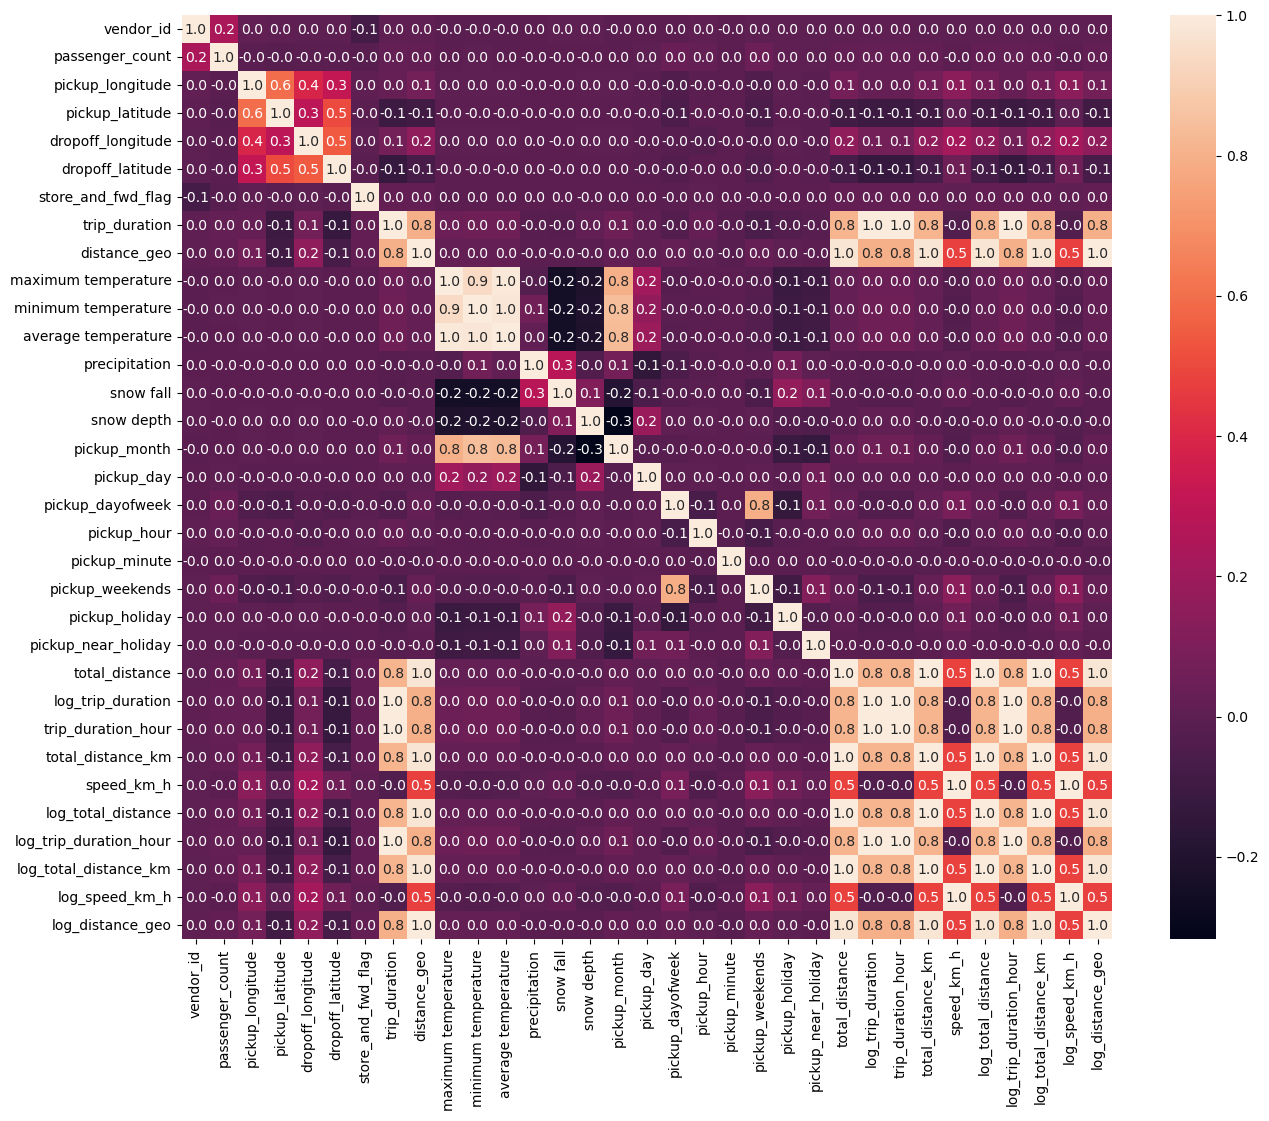

In [46]:
plt.figure(figsize=(15, 12))

sns.heatmap(df_all.corr(method='spearman'), annot=True, fmt=".1f")

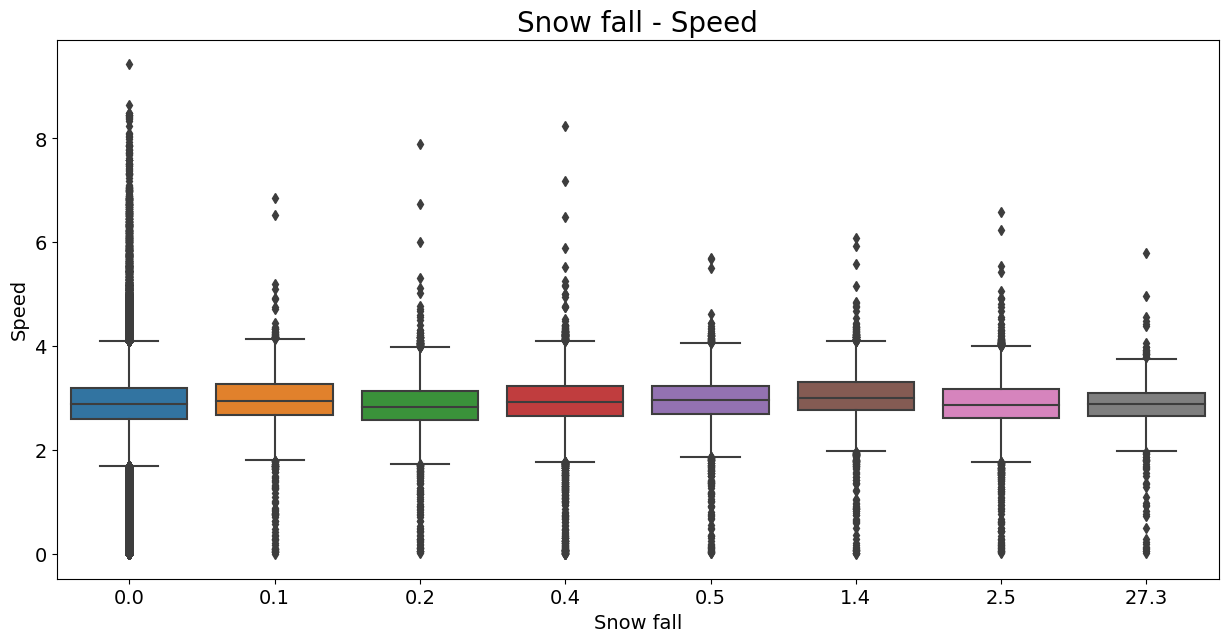

In [47]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_speed_km_h', data=df_all)

plt.title('Snow fall - Speed', fontsize=20)
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14); 

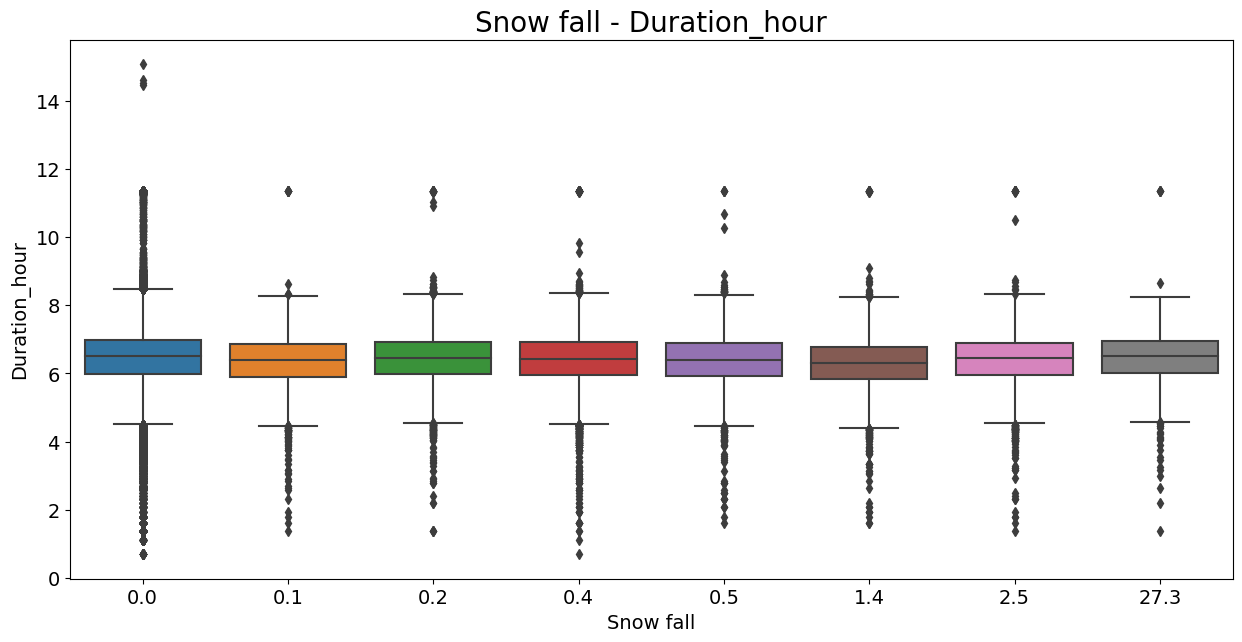

In [48]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_trip_duration', data=df_all)

plt.title('Snow fall - Duration_hour', fontsize=20)
plt.ylabel('Duration_hour', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14); 

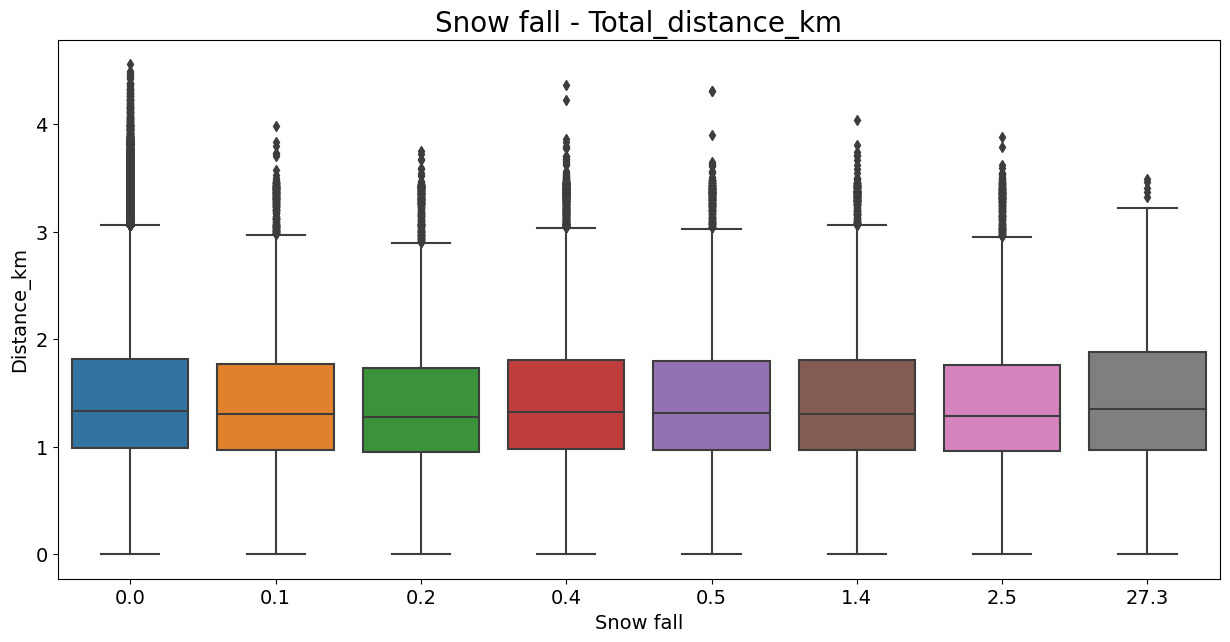

In [49]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='snow fall', y='log_total_distance_km', data=df_all)

plt.title('Snow fall - Total_distance_km', fontsize=20)
plt.ylabel('Distance_km', fontsize=14)
plt.xlabel('Snow fall', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

# 3.Modeling

## 3.1 LGBMRegressor + Optuna

In [50]:
import lightgbm as lg  # бустинг над решающими деревьями
import optuna # фреймворк для подбора оптимальных параметров

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold

optuna - фреймворк подбора оптимальных гиперпараметров, который использует байесовский подход для автоматизации пространства поиска гиперпараметров

In [51]:
# df_all.to_pickle('data/all_df.pickle')
# df_all = pd.read_pickle('data/all_df.pickle')

In [52]:
drop_cols_train = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    
    'distance_geo',
    
    'date',
    'total_distance',
    'total_distance_km',
    'log_total_distance_km',
    
    'trip_duration',
    'log_trip_duration',
    'trip_duration_hour',
    'log_trip_duration_hour',
    
    'speed_km_h',
    'log_speed_km_h'
]

In [53]:
X = df_all.drop(columns=drop_cols_train, axis=1)
y = df_all[['log_trip_duration']]

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size=TEST_SIZE,
                                                   random_state=RANDOM_STATE)

In [54]:
X_train[:2]

,vendor_id,passenger_count,store_and_fwd_flag,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth,pickup_month,pickup_day,pickup_dayofweek,pickup_hour,pickup_minute,pickup_weekends,pickup_holiday,pickup_near_holiday,log_total_distance,log_distance_geo
462481,2,3,0,72,52,62.00000,0.00000,0.00000,0.00000,5,9,0,22,11,0,0,0,9.88003,2.83378
794208,2,1,0,68,43,55.50000,0.00000,0.00000,0.00000,4,16,5,2,2,1,0,0,7.19143,0.67472


In [55]:
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric
    Логарифмическая ошибка средней квадратичной ошибки
    Более устойчива к выбросам
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [56]:
# целевая функция
def objective(trial, X, y):
    param_grid = {
        'n_estimators': trial.suggest_categorical('n_estimators', [1000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_levels', 20, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10, step=2),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 200, step=50)
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    # кросс валидация с 5 фолдами
    cv_predicts = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        prunning_callback = optuna.integration.LightGBMPruningCallback(
            trial, 'l2') #класс обратного вызова (для сокращения времени поиска оптимальных параметров)
        model = lg.LGBMRegressor(objective="regression" , verbose=-1, early_stopping_rounds=100, **param_grid)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric='rmsle',
#                   early_stopping_rounds=100,
                  callbacks=[prunning_callback])
#                   verbose=-1)
        preds = model.predict(X_test)
        cv_predicts[idx] = rmsle(y_test, preds)
        
    return np.mean(cv_predicts)

callbacks - класс обратного вызова, может обнаруживать берспективные наборы гиперпараметров перед обучением, тем самым значительно сокращая время поиска

In [57]:
study = optuna.create_study(direction='minimize', study_name='LGB') # минимизируем нашу функцию
func = lambda trial: objective(trial, X_train, y_train)
# n_trials - количество итераций
study.optimize(func, n_trials=5, show_progress_bar=True)

[I 2023-11-15 16:16:35,906] A new study created in memory with name: LGB


  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 0.54192
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.48124
[3]	valid_0's l2: 0.431763
[4]	valid_0's l2: 0.392164
[5]	valid_0's l2: 0.359533
[6]	valid_0's l2: 0.333602
[7]	valid_0's l2: 0.312535
[8]	valid_0's l2: 0.294743
[9]	valid_0's l2: 0.280645
[10]	valid_0's l2: 0.268872
[11]	valid_0's l2: 0.259367
[12]	valid_0's l2: 0.251392
[13]	valid_0's l2: 0.244845
[14]	valid_0's l2: 0.23948
[15]	valid_0's l2: 0.235052
[16]	valid_0's l2: 0.231109
[17]	valid_0's l2: 0.228034
[18]	valid_0's l2: 0.225219
[19]	valid_0's l2: 0.22286
[20]	valid_0's l2: 0.220734
[21]	valid_0's l2: 0.218745
[22]	valid_0's l2: 0.216982
[23]	valid_0's l2: 0.215476
[24]	valid_0's l2: 0.21412
[25]	valid_0's l2: 0.212774
[26]	valid_0's l2: 0.211426
[27]	valid_0's l2: 0.210441
[28]	valid_0's l2: 0.209353
[29]	valid_0's l2: 0.208391
[30

[287]	valid_0's l2: 0.185394
[288]	valid_0's l2: 0.185347
[289]	valid_0's l2: 0.185343
[290]	valid_0's l2: 0.18534
[291]	valid_0's l2: 0.18531
[292]	valid_0's l2: 0.185261
[293]	valid_0's l2: 0.185251
[294]	valid_0's l2: 0.18525
[295]	valid_0's l2: 0.185246
[296]	valid_0's l2: 0.185217
[297]	valid_0's l2: 0.185186
[298]	valid_0's l2: 0.185136
[299]	valid_0's l2: 0.18513
[300]	valid_0's l2: 0.185117
[301]	valid_0's l2: 0.185112
[302]	valid_0's l2: 0.185102
[303]	valid_0's l2: 0.18508
[304]	valid_0's l2: 0.18507
[305]	valid_0's l2: 0.185062
[306]	valid_0's l2: 0.185054
[307]	valid_0's l2: 0.185051
[308]	valid_0's l2: 0.18504
[309]	valid_0's l2: 0.184994
[310]	valid_0's l2: 0.184985
[311]	valid_0's l2: 0.184963
[312]	valid_0's l2: 0.184953
[313]	valid_0's l2: 0.18494
[314]	valid_0's l2: 0.184938
[315]	valid_0's l2: 0.184939
[316]	valid_0's l2: 0.184915
[317]	valid_0's l2: 0.184901
[318]	valid_0's l2: 0.1849
[319]	valid_0's l2: 0.184876
[320]	valid_0's l2: 0.184858
[321]	valid_0's l2: 0.18

[574]	valid_0's l2: 0.182959
[575]	valid_0's l2: 0.182959
[576]	valid_0's l2: 0.182953
[577]	valid_0's l2: 0.182953
[578]	valid_0's l2: 0.182953
[579]	valid_0's l2: 0.182952
[580]	valid_0's l2: 0.182948
[581]	valid_0's l2: 0.182951
[582]	valid_0's l2: 0.182947
[583]	valid_0's l2: 0.182943
[584]	valid_0's l2: 0.182935
[585]	valid_0's l2: 0.182931
[586]	valid_0's l2: 0.182928
[587]	valid_0's l2: 0.182933
[588]	valid_0's l2: 0.182926
[589]	valid_0's l2: 0.182926
[590]	valid_0's l2: 0.182922
[591]	valid_0's l2: 0.182916
[592]	valid_0's l2: 0.18291
[593]	valid_0's l2: 0.182905
[594]	valid_0's l2: 0.182899
[595]	valid_0's l2: 0.182897
[596]	valid_0's l2: 0.182898
[597]	valid_0's l2: 0.182891
[598]	valid_0's l2: 0.18289
[599]	valid_0's l2: 0.182888
[600]	valid_0's l2: 0.182886
[601]	valid_0's l2: 0.182885
[602]	valid_0's l2: 0.182886
[603]	valid_0's l2: 0.182884
[604]	valid_0's l2: 0.182889
[605]	valid_0's l2: 0.182882
[606]	valid_0's l2: 0.182877
[607]	valid_0's l2: 0.182875
[608]	valid_0's 

[868]	valid_0's l2: 0.182305
[869]	valid_0's l2: 0.182303
[870]	valid_0's l2: 0.182302
[871]	valid_0's l2: 0.1823
[872]	valid_0's l2: 0.182296
[873]	valid_0's l2: 0.182295
[874]	valid_0's l2: 0.182298
[875]	valid_0's l2: 0.182296
[876]	valid_0's l2: 0.182294
[877]	valid_0's l2: 0.182293
[878]	valid_0's l2: 0.182287
[879]	valid_0's l2: 0.182287
[880]	valid_0's l2: 0.182286
[881]	valid_0's l2: 0.182284
[882]	valid_0's l2: 0.182283
[883]	valid_0's l2: 0.182283
[884]	valid_0's l2: 0.182282
[885]	valid_0's l2: 0.182278
[886]	valid_0's l2: 0.182277
[887]	valid_0's l2: 0.182274
[888]	valid_0's l2: 0.182266
[889]	valid_0's l2: 0.182265
[890]	valid_0's l2: 0.182264
[891]	valid_0's l2: 0.182261
[892]	valid_0's l2: 0.18227
[893]	valid_0's l2: 0.182272
[894]	valid_0's l2: 0.182271
[895]	valid_0's l2: 0.18227
[896]	valid_0's l2: 0.182274
[897]	valid_0's l2: 0.182275
[898]	valid_0's l2: 0.182274
[899]	valid_0's l2: 0.18227
[900]	valid_0's l2: 0.182267
[901]	valid_0's l2: 0.182263
[902]	valid_0's l2:

[149]	valid_0's l2: 0.188882
[150]	valid_0's l2: 0.188845
[151]	valid_0's l2: 0.188819
[152]	valid_0's l2: 0.188675
[153]	valid_0's l2: 0.188655
[154]	valid_0's l2: 0.188554
[155]	valid_0's l2: 0.188537
[156]	valid_0's l2: 0.188524
[157]	valid_0's l2: 0.188485
[158]	valid_0's l2: 0.188474
[159]	valid_0's l2: 0.188437
[160]	valid_0's l2: 0.188428
[161]	valid_0's l2: 0.188389
[162]	valid_0's l2: 0.188373
[163]	valid_0's l2: 0.188354
[164]	valid_0's l2: 0.188303
[165]	valid_0's l2: 0.188253
[166]	valid_0's l2: 0.188226
[167]	valid_0's l2: 0.1882
[168]	valid_0's l2: 0.188173
[169]	valid_0's l2: 0.188166
[170]	valid_0's l2: 0.188155
[171]	valid_0's l2: 0.188138
[172]	valid_0's l2: 0.188124
[173]	valid_0's l2: 0.188122
[174]	valid_0's l2: 0.188106
[175]	valid_0's l2: 0.188092
[176]	valid_0's l2: 0.188084
[177]	valid_0's l2: 0.188066
[178]	valid_0's l2: 0.188046
[179]	valid_0's l2: 0.187908
[180]	valid_0's l2: 0.18789
[181]	valid_0's l2: 0.187856
[182]	valid_0's l2: 0.187848
[183]	valid_0's l

[443]	valid_0's l2: 0.184248
[444]	valid_0's l2: 0.184237
[445]	valid_0's l2: 0.18421
[446]	valid_0's l2: 0.184188
[447]	valid_0's l2: 0.184179
[448]	valid_0's l2: 0.184171
[449]	valid_0's l2: 0.184162
[450]	valid_0's l2: 0.184154
[451]	valid_0's l2: 0.184147
[452]	valid_0's l2: 0.184144
[453]	valid_0's l2: 0.184142
[454]	valid_0's l2: 0.184138
[455]	valid_0's l2: 0.184125
[456]	valid_0's l2: 0.184121
[457]	valid_0's l2: 0.184117
[458]	valid_0's l2: 0.184114
[459]	valid_0's l2: 0.184112
[460]	valid_0's l2: 0.18411
[461]	valid_0's l2: 0.184104
[462]	valid_0's l2: 0.184103
[463]	valid_0's l2: 0.184092
[464]	valid_0's l2: 0.184061
[465]	valid_0's l2: 0.184054
[466]	valid_0's l2: 0.184028
[467]	valid_0's l2: 0.184022
[468]	valid_0's l2: 0.184022
[469]	valid_0's l2: 0.184018
[470]	valid_0's l2: 0.184014
[471]	valid_0's l2: 0.183998
[472]	valid_0's l2: 0.183999
[473]	valid_0's l2: 0.183977
[474]	valid_0's l2: 0.183963
[475]	valid_0's l2: 0.18396
[476]	valid_0's l2: 0.183944
[477]	valid_0's l

[729]	valid_0's l2: 0.18288
[730]	valid_0's l2: 0.182878
[731]	valid_0's l2: 0.182876
[732]	valid_0's l2: 0.182878
[733]	valid_0's l2: 0.182878
[734]	valid_0's l2: 0.182878
[735]	valid_0's l2: 0.182875
[736]	valid_0's l2: 0.182874
[737]	valid_0's l2: 0.182872
[738]	valid_0's l2: 0.182871
[739]	valid_0's l2: 0.18287
[740]	valid_0's l2: 0.182868
[741]	valid_0's l2: 0.182864
[742]	valid_0's l2: 0.182862
[743]	valid_0's l2: 0.182861
[744]	valid_0's l2: 0.182861
[745]	valid_0's l2: 0.182859
[746]	valid_0's l2: 0.18286
[747]	valid_0's l2: 0.182861
[748]	valid_0's l2: 0.182859
[749]	valid_0's l2: 0.182856
[750]	valid_0's l2: 0.182857
[751]	valid_0's l2: 0.182853
[752]	valid_0's l2: 0.182848
[753]	valid_0's l2: 0.182844
[754]	valid_0's l2: 0.182842
[755]	valid_0's l2: 0.182839
[756]	valid_0's l2: 0.182836
[757]	valid_0's l2: 0.182833
[758]	valid_0's l2: 0.182832
[759]	valid_0's l2: 0.182829
[760]	valid_0's l2: 0.182823
[761]	valid_0's l2: 0.182822
[762]	valid_0's l2: 0.182821
[763]	valid_0's l

[12]	valid_0's l2: 0.244852
[13]	valid_0's l2: 0.238424
[14]	valid_0's l2: 0.232936
[15]	valid_0's l2: 0.228503
[16]	valid_0's l2: 0.224555
[17]	valid_0's l2: 0.22141
[18]	valid_0's l2: 0.218691
[19]	valid_0's l2: 0.216401
[20]	valid_0's l2: 0.214465
[21]	valid_0's l2: 0.212492
[22]	valid_0's l2: 0.210753
[23]	valid_0's l2: 0.20916
[24]	valid_0's l2: 0.207636
[25]	valid_0's l2: 0.206369
[26]	valid_0's l2: 0.205207
[27]	valid_0's l2: 0.204145
[28]	valid_0's l2: 0.203125
[29]	valid_0's l2: 0.20229
[30]	valid_0's l2: 0.201421
[31]	valid_0's l2: 0.200672
[32]	valid_0's l2: 0.200014
[33]	valid_0's l2: 0.199125
[34]	valid_0's l2: 0.198637
[35]	valid_0's l2: 0.198021
[36]	valid_0's l2: 0.197535
[37]	valid_0's l2: 0.196997
[38]	valid_0's l2: 0.196553
[39]	valid_0's l2: 0.196029
[40]	valid_0's l2: 0.195537
[41]	valid_0's l2: 0.195126
[42]	valid_0's l2: 0.19452
[43]	valid_0's l2: 0.194141
[44]	valid_0's l2: 0.193828
[45]	valid_0's l2: 0.193545
[46]	valid_0's l2: 0.193239
[47]	valid_0's l2: 0.192

[304]	valid_0's l2: 0.179217
[305]	valid_0's l2: 0.179202
[306]	valid_0's l2: 0.179204
[307]	valid_0's l2: 0.179192
[308]	valid_0's l2: 0.17917
[309]	valid_0's l2: 0.179166
[310]	valid_0's l2: 0.179134
[311]	valid_0's l2: 0.179128
[312]	valid_0's l2: 0.179121
[313]	valid_0's l2: 0.179113
[314]	valid_0's l2: 0.179105
[315]	valid_0's l2: 0.179092
[316]	valid_0's l2: 0.179066
[317]	valid_0's l2: 0.179048
[318]	valid_0's l2: 0.179038
[319]	valid_0's l2: 0.179024
[320]	valid_0's l2: 0.179005
[321]	valid_0's l2: 0.178987
[322]	valid_0's l2: 0.178981
[323]	valid_0's l2: 0.178971
[324]	valid_0's l2: 0.178958
[325]	valid_0's l2: 0.178931
[326]	valid_0's l2: 0.178922
[327]	valid_0's l2: 0.178907
[328]	valid_0's l2: 0.178883
[329]	valid_0's l2: 0.178876
[330]	valid_0's l2: 0.178873
[331]	valid_0's l2: 0.178863
[332]	valid_0's l2: 0.178854
[333]	valid_0's l2: 0.178845
[334]	valid_0's l2: 0.178832
[335]	valid_0's l2: 0.178819
[336]	valid_0's l2: 0.178797
[337]	valid_0's l2: 0.178793
[338]	valid_0's

[591]	valid_0's l2: 0.177001
[592]	valid_0's l2: 0.176994
[593]	valid_0's l2: 0.176994
[594]	valid_0's l2: 0.176995
[595]	valid_0's l2: 0.176993
[596]	valid_0's l2: 0.176991
[597]	valid_0's l2: 0.176995
[598]	valid_0's l2: 0.176992
[599]	valid_0's l2: 0.176987
[600]	valid_0's l2: 0.176985
[601]	valid_0's l2: 0.176985
[602]	valid_0's l2: 0.176982
[603]	valid_0's l2: 0.176981
[604]	valid_0's l2: 0.176978
[605]	valid_0's l2: 0.17697
[606]	valid_0's l2: 0.176966
[607]	valid_0's l2: 0.176962
[608]	valid_0's l2: 0.176942
[609]	valid_0's l2: 0.176936
[610]	valid_0's l2: 0.176924
[611]	valid_0's l2: 0.176917
[612]	valid_0's l2: 0.176915
[613]	valid_0's l2: 0.176909
[614]	valid_0's l2: 0.176905
[615]	valid_0's l2: 0.176902
[616]	valid_0's l2: 0.176894
[617]	valid_0's l2: 0.176892
[618]	valid_0's l2: 0.176892
[619]	valid_0's l2: 0.176885
[620]	valid_0's l2: 0.176885
[621]	valid_0's l2: 0.176878
[622]	valid_0's l2: 0.176867
[623]	valid_0's l2: 0.176873
[624]	valid_0's l2: 0.176871
[625]	valid_0's

[883]	valid_0's l2: 0.17615
[884]	valid_0's l2: 0.176145
[885]	valid_0's l2: 0.17614
[886]	valid_0's l2: 0.176139
[887]	valid_0's l2: 0.176138
[888]	valid_0's l2: 0.176136
[889]	valid_0's l2: 0.176136
[890]	valid_0's l2: 0.176134
[891]	valid_0's l2: 0.176133
[892]	valid_0's l2: 0.176131
[893]	valid_0's l2: 0.176124
[894]	valid_0's l2: 0.176123
[895]	valid_0's l2: 0.176123
[896]	valid_0's l2: 0.176121
[897]	valid_0's l2: 0.176122
[898]	valid_0's l2: 0.176121
[899]	valid_0's l2: 0.176123
[900]	valid_0's l2: 0.176121
[901]	valid_0's l2: 0.176128
[902]	valid_0's l2: 0.176124
[903]	valid_0's l2: 0.176121
[904]	valid_0's l2: 0.176119
[905]	valid_0's l2: 0.176125
[906]	valid_0's l2: 0.176128
[907]	valid_0's l2: 0.176135
[908]	valid_0's l2: 0.176131
[909]	valid_0's l2: 0.176117
[910]	valid_0's l2: 0.176122
[911]	valid_0's l2: 0.176124
[912]	valid_0's l2: 0.176133
[913]	valid_0's l2: 0.176134
[914]	valid_0's l2: 0.176132
[915]	valid_0's l2: 0.176131
[916]	valid_0's l2: 0.176134
[917]	valid_0's 

[165]	valid_0's l2: 0.181168
[166]	valid_0's l2: 0.181145
[167]	valid_0's l2: 0.18112
[168]	valid_0's l2: 0.181091
[169]	valid_0's l2: 0.181086
[170]	valid_0's l2: 0.181034
[171]	valid_0's l2: 0.181035
[172]	valid_0's l2: 0.181005
[173]	valid_0's l2: 0.180993
[174]	valid_0's l2: 0.180986
[175]	valid_0's l2: 0.180971
[176]	valid_0's l2: 0.18095
[177]	valid_0's l2: 0.180925
[178]	valid_0's l2: 0.180885
[179]	valid_0's l2: 0.180863
[180]	valid_0's l2: 0.180832
[181]	valid_0's l2: 0.180823
[182]	valid_0's l2: 0.180801
[183]	valid_0's l2: 0.180787
[184]	valid_0's l2: 0.180679
[185]	valid_0's l2: 0.180653
[186]	valid_0's l2: 0.180633
[187]	valid_0's l2: 0.180616
[188]	valid_0's l2: 0.180609
[189]	valid_0's l2: 0.180603
[190]	valid_0's l2: 0.18059
[191]	valid_0's l2: 0.180566
[192]	valid_0's l2: 0.180538
[193]	valid_0's l2: 0.180519
[194]	valid_0's l2: 0.180434
[195]	valid_0's l2: 0.18042
[196]	valid_0's l2: 0.180393
[197]	valid_0's l2: 0.180378
[198]	valid_0's l2: 0.180363
[199]	valid_0's l2

[452]	valid_0's l2: 0.177179
[453]	valid_0's l2: 0.177174
[454]	valid_0's l2: 0.177172
[455]	valid_0's l2: 0.177167
[456]	valid_0's l2: 0.177167
[457]	valid_0's l2: 0.177156
[458]	valid_0's l2: 0.177153
[459]	valid_0's l2: 0.177133
[460]	valid_0's l2: 0.177118
[461]	valid_0's l2: 0.177112
[462]	valid_0's l2: 0.1771
[463]	valid_0's l2: 0.177097
[464]	valid_0's l2: 0.177091
[465]	valid_0's l2: 0.177088
[466]	valid_0's l2: 0.177081
[467]	valid_0's l2: 0.177081
[468]	valid_0's l2: 0.177079
[469]	valid_0's l2: 0.17708
[470]	valid_0's l2: 0.17707
[471]	valid_0's l2: 0.177061
[472]	valid_0's l2: 0.177057
[473]	valid_0's l2: 0.177055
[474]	valid_0's l2: 0.177047
[475]	valid_0's l2: 0.177044
[476]	valid_0's l2: 0.177045
[477]	valid_0's l2: 0.177042
[478]	valid_0's l2: 0.177037
[479]	valid_0's l2: 0.177033
[480]	valid_0's l2: 0.177035
[481]	valid_0's l2: 0.177033
[482]	valid_0's l2: 0.177029
[483]	valid_0's l2: 0.177026
[484]	valid_0's l2: 0.177024
[485]	valid_0's l2: 0.177026
[486]	valid_0's l2

[741]	valid_0's l2: 0.176017
[742]	valid_0's l2: 0.176012
[743]	valid_0's l2: 0.17601
[744]	valid_0's l2: 0.176012
[745]	valid_0's l2: 0.176012
[746]	valid_0's l2: 0.176024
[747]	valid_0's l2: 0.176021
[748]	valid_0's l2: 0.17602
[749]	valid_0's l2: 0.176019
[750]	valid_0's l2: 0.176018
[751]	valid_0's l2: 0.176016
[752]	valid_0's l2: 0.176013
[753]	valid_0's l2: 0.176011
[754]	valid_0's l2: 0.176009
[755]	valid_0's l2: 0.176011
[756]	valid_0's l2: 0.176011
[757]	valid_0's l2: 0.176012
[758]	valid_0's l2: 0.17601
[759]	valid_0's l2: 0.176005
[760]	valid_0's l2: 0.176007
[761]	valid_0's l2: 0.176006
[762]	valid_0's l2: 0.176003
[763]	valid_0's l2: 0.176002
[764]	valid_0's l2: 0.175996
[765]	valid_0's l2: 0.175993
[766]	valid_0's l2: 0.175993
[767]	valid_0's l2: 0.175991
[768]	valid_0's l2: 0.175994
[769]	valid_0's l2: 0.175996
[770]	valid_0's l2: 0.175995
[771]	valid_0's l2: 0.175992
[772]	valid_0's l2: 0.175989
[773]	valid_0's l2: 0.175988
[774]	valid_0's l2: 0.175993
[775]	valid_0's l

[21]	valid_0's l2: 0.216088
[22]	valid_0's l2: 0.214216
[23]	valid_0's l2: 0.212533
[24]	valid_0's l2: 0.21115
[25]	valid_0's l2: 0.209837
[26]	valid_0's l2: 0.208687
[27]	valid_0's l2: 0.207417
[28]	valid_0's l2: 0.206471
[29]	valid_0's l2: 0.205609
[30]	valid_0's l2: 0.204652
[31]	valid_0's l2: 0.204019
[32]	valid_0's l2: 0.203064
[33]	valid_0's l2: 0.202401
[34]	valid_0's l2: 0.201847
[35]	valid_0's l2: 0.201211
[36]	valid_0's l2: 0.200729
[37]	valid_0's l2: 0.200239
[38]	valid_0's l2: 0.199497
[39]	valid_0's l2: 0.199003
[40]	valid_0's l2: 0.198547
[41]	valid_0's l2: 0.198131
[42]	valid_0's l2: 0.19775
[43]	valid_0's l2: 0.197401
[44]	valid_0's l2: 0.197061
[45]	valid_0's l2: 0.196654
[46]	valid_0's l2: 0.196339
[47]	valid_0's l2: 0.195936
[48]	valid_0's l2: 0.195647
[49]	valid_0's l2: 0.195342
[50]	valid_0's l2: 0.195109
[51]	valid_0's l2: 0.194815
[52]	valid_0's l2: 0.194511
[53]	valid_0's l2: 0.194211
[54]	valid_0's l2: 0.193945
[55]	valid_0's l2: 0.193575
[56]	valid_0's l2: 0.1

[310]	valid_0's l2: 0.182093
[311]	valid_0's l2: 0.182076
[312]	valid_0's l2: 0.182035
[313]	valid_0's l2: 0.182031
[314]	valid_0's l2: 0.182002
[315]	valid_0's l2: 0.181942
[316]	valid_0's l2: 0.181912
[317]	valid_0's l2: 0.1819
[318]	valid_0's l2: 0.181901
[319]	valid_0's l2: 0.181901
[320]	valid_0's l2: 0.181898
[321]	valid_0's l2: 0.181879
[322]	valid_0's l2: 0.181872
[323]	valid_0's l2: 0.181867
[324]	valid_0's l2: 0.181866
[325]	valid_0's l2: 0.181864
[326]	valid_0's l2: 0.181861
[327]	valid_0's l2: 0.181855
[328]	valid_0's l2: 0.181803
[329]	valid_0's l2: 0.1818
[330]	valid_0's l2: 0.181789
[331]	valid_0's l2: 0.181785
[332]	valid_0's l2: 0.18178
[333]	valid_0's l2: 0.181778
[334]	valid_0's l2: 0.181745
[335]	valid_0's l2: 0.181727
[336]	valid_0's l2: 0.181717
[337]	valid_0's l2: 0.181704
[338]	valid_0's l2: 0.181701
[339]	valid_0's l2: 0.181696
[340]	valid_0's l2: 0.18169
[341]	valid_0's l2: 0.181682
[342]	valid_0's l2: 0.181651
[343]	valid_0's l2: 0.181608
[344]	valid_0's l2: 

[604]	valid_0's l2: 0.179783
[605]	valid_0's l2: 0.179781
[606]	valid_0's l2: 0.179779
[607]	valid_0's l2: 0.179767
[608]	valid_0's l2: 0.179758
[609]	valid_0's l2: 0.179756
[610]	valid_0's l2: 0.179756
[611]	valid_0's l2: 0.179754
[612]	valid_0's l2: 0.179749
[613]	valid_0's l2: 0.179745
[614]	valid_0's l2: 0.179742
[615]	valid_0's l2: 0.179741
[616]	valid_0's l2: 0.179734
[617]	valid_0's l2: 0.17973
[618]	valid_0's l2: 0.179731
[619]	valid_0's l2: 0.17973
[620]	valid_0's l2: 0.179725
[621]	valid_0's l2: 0.179722
[622]	valid_0's l2: 0.179719
[623]	valid_0's l2: 0.179716
[624]	valid_0's l2: 0.179718
[625]	valid_0's l2: 0.179722
[626]	valid_0's l2: 0.179721
[627]	valid_0's l2: 0.179718
[628]	valid_0's l2: 0.179719
[629]	valid_0's l2: 0.179717
[630]	valid_0's l2: 0.179713
[631]	valid_0's l2: 0.179709
[632]	valid_0's l2: 0.179688
[633]	valid_0's l2: 0.179685
[634]	valid_0's l2: 0.179683
[635]	valid_0's l2: 0.179678
[636]	valid_0's l2: 0.179673
[637]	valid_0's l2: 0.179668
[638]	valid_0's 

[890]	valid_0's l2: 0.179161
[891]	valid_0's l2: 0.179151
[892]	valid_0's l2: 0.179149
[893]	valid_0's l2: 0.179146
[894]	valid_0's l2: 0.179134
[895]	valid_0's l2: 0.179127
[896]	valid_0's l2: 0.17912
[897]	valid_0's l2: 0.17912
[898]	valid_0's l2: 0.179111
[899]	valid_0's l2: 0.179108
[900]	valid_0's l2: 0.179107
[901]	valid_0's l2: 0.179106
[902]	valid_0's l2: 0.179105
[903]	valid_0's l2: 0.179109
[904]	valid_0's l2: 0.179107
[905]	valid_0's l2: 0.17911
[906]	valid_0's l2: 0.179109
[907]	valid_0's l2: 0.179107
[908]	valid_0's l2: 0.179106
[909]	valid_0's l2: 0.179099
[910]	valid_0's l2: 0.179098
[911]	valid_0's l2: 0.179097
[912]	valid_0's l2: 0.179097
[913]	valid_0's l2: 0.179096
[914]	valid_0's l2: 0.1791
[915]	valid_0's l2: 0.179099
[916]	valid_0's l2: 0.179097
[917]	valid_0's l2: 0.179098
[918]	valid_0's l2: 0.179094
[919]	valid_0's l2: 0.179091
[920]	valid_0's l2: 0.179091
[921]	valid_0's l2: 0.179088
[922]	valid_0's l2: 0.179087
[923]	valid_0's l2: 0.179085
[924]	valid_0's l2:

[159]	valid_0's l2: 0.181862
[160]	valid_0's l2: 0.181855
[161]	valid_0's l2: 0.181853
[162]	valid_0's l2: 0.181847
[163]	valid_0's l2: 0.181842
[164]	valid_0's l2: 0.181835
[165]	valid_0's l2: 0.181848
[166]	valid_0's l2: 0.181836
[167]	valid_0's l2: 0.181816
[168]	valid_0's l2: 0.181821
[169]	valid_0's l2: 0.181817
[170]	valid_0's l2: 0.181804
[171]	valid_0's l2: 0.181791
[172]	valid_0's l2: 0.181794
[173]	valid_0's l2: 0.181775
[174]	valid_0's l2: 0.181766
[175]	valid_0's l2: 0.181746
[176]	valid_0's l2: 0.181733
[177]	valid_0's l2: 0.181716
[178]	valid_0's l2: 0.181716
[179]	valid_0's l2: 0.181693
[180]	valid_0's l2: 0.18169
[181]	valid_0's l2: 0.181687
[182]	valid_0's l2: 0.181685
[183]	valid_0's l2: 0.18168
[184]	valid_0's l2: 0.181681
[185]	valid_0's l2: 0.181691
[186]	valid_0's l2: 0.18169
[187]	valid_0's l2: 0.181688
[188]	valid_0's l2: 0.181695
[189]	valid_0's l2: 0.181689
[190]	valid_0's l2: 0.181692
[191]	valid_0's l2: 0.181699
[192]	valid_0's l2: 0.181692
[193]	valid_0's l

[7]	valid_0's l2: 0.228513
[8]	valid_0's l2: 0.219319
[9]	valid_0's l2: 0.213282
[10]	valid_0's l2: 0.208834
[11]	valid_0's l2: 0.205697
[12]	valid_0's l2: 0.203139
[13]	valid_0's l2: 0.201146
[14]	valid_0's l2: 0.199655
[15]	valid_0's l2: 0.198391
[16]	valid_0's l2: 0.19749
[17]	valid_0's l2: 0.19617
[18]	valid_0's l2: 0.195206
[19]	valid_0's l2: 0.194565
[20]	valid_0's l2: 0.19408
[21]	valid_0's l2: 0.193058
[22]	valid_0's l2: 0.192608
[23]	valid_0's l2: 0.192167
[24]	valid_0's l2: 0.191657
[25]	valid_0's l2: 0.190986
[26]	valid_0's l2: 0.190573
[27]	valid_0's l2: 0.190346
[28]	valid_0's l2: 0.190092
[29]	valid_0's l2: 0.189914
[30]	valid_0's l2: 0.189686
[31]	valid_0's l2: 0.189449
[32]	valid_0's l2: 0.189288
[33]	valid_0's l2: 0.188541
[34]	valid_0's l2: 0.188398
[35]	valid_0's l2: 0.188143
[36]	valid_0's l2: 0.187653
[37]	valid_0's l2: 0.187515
[38]	valid_0's l2: 0.187385
[39]	valid_0's l2: 0.187166
[40]	valid_0's l2: 0.186923
[41]	valid_0's l2: 0.186809
[42]	valid_0's l2: 0.18667

[303]	valid_0's l2: 0.181776
[304]	valid_0's l2: 0.181779
[305]	valid_0's l2: 0.181781
[306]	valid_0's l2: 0.18178
[307]	valid_0's l2: 0.181775
[308]	valid_0's l2: 0.181774
[309]	valid_0's l2: 0.181772
[310]	valid_0's l2: 0.181776
[311]	valid_0's l2: 0.181776
[312]	valid_0's l2: 0.181769
[313]	valid_0's l2: 0.181766
[314]	valid_0's l2: 0.181762
[315]	valid_0's l2: 0.181759
[316]	valid_0's l2: 0.18176
[317]	valid_0's l2: 0.181762
[318]	valid_0's l2: 0.18179
[319]	valid_0's l2: 0.181784
[320]	valid_0's l2: 0.181785
[321]	valid_0's l2: 0.181787
[322]	valid_0's l2: 0.181783
[323]	valid_0's l2: 0.181782
[324]	valid_0's l2: 0.181783
[325]	valid_0's l2: 0.181777
[326]	valid_0's l2: 0.181785
[327]	valid_0's l2: 0.181785
[328]	valid_0's l2: 0.181784
[329]	valid_0's l2: 0.18181
[330]	valid_0's l2: 0.181807
[331]	valid_0's l2: 0.18181
[332]	valid_0's l2: 0.181811
[333]	valid_0's l2: 0.181819
[334]	valid_0's l2: 0.181816
[335]	valid_0's l2: 0.181809
[336]	valid_0's l2: 0.181809
[337]	valid_0's l2:

[209]	valid_0's l2: 0.175446
[210]	valid_0's l2: 0.175437
[211]	valid_0's l2: 0.175437
[212]	valid_0's l2: 0.175435
[213]	valid_0's l2: 0.175444
[214]	valid_0's l2: 0.175435
[215]	valid_0's l2: 0.175433
[216]	valid_0's l2: 0.175429
[217]	valid_0's l2: 0.175421
[218]	valid_0's l2: 0.175425
[219]	valid_0's l2: 0.175418
[220]	valid_0's l2: 0.175406
[221]	valid_0's l2: 0.175394
[222]	valid_0's l2: 0.175392
[223]	valid_0's l2: 0.175383
[224]	valid_0's l2: 0.175365
[225]	valid_0's l2: 0.175381
[226]	valid_0's l2: 0.175373
[227]	valid_0's l2: 0.175375
[228]	valid_0's l2: 0.175366
[229]	valid_0's l2: 0.175375
[230]	valid_0's l2: 0.175361
[231]	valid_0's l2: 0.175351
[232]	valid_0's l2: 0.175343
[233]	valid_0's l2: 0.175355
[234]	valid_0's l2: 0.175354
[235]	valid_0's l2: 0.175346
[236]	valid_0's l2: 0.175353
[237]	valid_0's l2: 0.175353
[238]	valid_0's l2: 0.175367
[239]	valid_0's l2: 0.175362
[240]	valid_0's l2: 0.175353
[241]	valid_0's l2: 0.175351
[242]	valid_0's l2: 0.175362
[243]	valid_0'

[141]	valid_0's l2: 0.175759
[142]	valid_0's l2: 0.175736
[143]	valid_0's l2: 0.175721
[144]	valid_0's l2: 0.175713
[145]	valid_0's l2: 0.175703
[146]	valid_0's l2: 0.175698
[147]	valid_0's l2: 0.175695
[148]	valid_0's l2: 0.175678
[149]	valid_0's l2: 0.175668
[150]	valid_0's l2: 0.175666
[151]	valid_0's l2: 0.175655
[152]	valid_0's l2: 0.175638
[153]	valid_0's l2: 0.175669
[154]	valid_0's l2: 0.175702
[155]	valid_0's l2: 0.175697
[156]	valid_0's l2: 0.175696
[157]	valid_0's l2: 0.175671
[158]	valid_0's l2: 0.175659
[159]	valid_0's l2: 0.175667
[160]	valid_0's l2: 0.175672
[161]	valid_0's l2: 0.175671
[162]	valid_0's l2: 0.17566
[163]	valid_0's l2: 0.175632
[164]	valid_0's l2: 0.1756
[165]	valid_0's l2: 0.175589
[166]	valid_0's l2: 0.175586
[167]	valid_0's l2: 0.175565
[168]	valid_0's l2: 0.17556
[169]	valid_0's l2: 0.175565
[170]	valid_0's l2: 0.175575
[171]	valid_0's l2: 0.175573
[172]	valid_0's l2: 0.175567
[173]	valid_0's l2: 0.175573
[174]	valid_0's l2: 0.17557
[175]	valid_0's l2:

[73]	valid_0's l2: 0.180745
[74]	valid_0's l2: 0.180734
[75]	valid_0's l2: 0.180717
[76]	valid_0's l2: 0.180685
[77]	valid_0's l2: 0.180678
[78]	valid_0's l2: 0.180672
[79]	valid_0's l2: 0.180614
[80]	valid_0's l2: 0.180534
[81]	valid_0's l2: 0.180439
[82]	valid_0's l2: 0.180397
[83]	valid_0's l2: 0.180288
[84]	valid_0's l2: 0.180285
[85]	valid_0's l2: 0.180222
[86]	valid_0's l2: 0.18021
[87]	valid_0's l2: 0.180196
[88]	valid_0's l2: 0.180114
[89]	valid_0's l2: 0.180116
[90]	valid_0's l2: 0.180082
[91]	valid_0's l2: 0.180009
[92]	valid_0's l2: 0.180003
[93]	valid_0's l2: 0.180003
[94]	valid_0's l2: 0.179989
[95]	valid_0's l2: 0.179984
[96]	valid_0's l2: 0.179961
[97]	valid_0's l2: 0.179911
[98]	valid_0's l2: 0.17986
[99]	valid_0's l2: 0.179761
[100]	valid_0's l2: 0.179716
[101]	valid_0's l2: 0.179704
[102]	valid_0's l2: 0.179726
[103]	valid_0's l2: 0.179723
[104]	valid_0's l2: 0.179723
[105]	valid_0's l2: 0.179682
[106]	valid_0's l2: 0.179666
[107]	valid_0's l2: 0.179668
[108]	valid_0'

[364]	valid_0's l2: 0.178682
[365]	valid_0's l2: 0.17869
[366]	valid_0's l2: 0.178687
[367]	valid_0's l2: 0.178687
[368]	valid_0's l2: 0.17869
[369]	valid_0's l2: 0.178691
[370]	valid_0's l2: 0.178691
[371]	valid_0's l2: 0.178686
[372]	valid_0's l2: 0.178677
[373]	valid_0's l2: 0.178682
[374]	valid_0's l2: 0.17868
[375]	valid_0's l2: 0.178683
[376]	valid_0's l2: 0.178702
[377]	valid_0's l2: 0.178699
[378]	valid_0's l2: 0.178706
[379]	valid_0's l2: 0.178702
[380]	valid_0's l2: 0.178711
[381]	valid_0's l2: 0.178709
[382]	valid_0's l2: 0.178714
[383]	valid_0's l2: 0.178719
Early stopping, best iteration is:
[283]	valid_0's l2: 0.178547
[I 2023-11-15 16:19:10,631] Trial 1 finished with value: 0.05964733776177076 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1904258744116267, 'num_levels': 270, 'max_depth': 5, 'min_child_samples': 155}. Best is trial 1 with value: 0.05964733776177076.
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored

[260]	valid_0's l2: 0.181835
[261]	valid_0's l2: 0.181828
[262]	valid_0's l2: 0.181821
[263]	valid_0's l2: 0.18182
[264]	valid_0's l2: 0.181807
[265]	valid_0's l2: 0.181801
[266]	valid_0's l2: 0.181786
[267]	valid_0's l2: 0.181776
[268]	valid_0's l2: 0.181777
[269]	valid_0's l2: 0.181778
[270]	valid_0's l2: 0.181773
[271]	valid_0's l2: 0.181768
[272]	valid_0's l2: 0.181762
[273]	valid_0's l2: 0.181755
[274]	valid_0's l2: 0.181738
[275]	valid_0's l2: 0.181733
[276]	valid_0's l2: 0.18173
[277]	valid_0's l2: 0.181724
[278]	valid_0's l2: 0.181722
[279]	valid_0's l2: 0.181729
[280]	valid_0's l2: 0.181715
[281]	valid_0's l2: 0.181717
[282]	valid_0's l2: 0.181727
[283]	valid_0's l2: 0.181729
[284]	valid_0's l2: 0.181727
[285]	valid_0's l2: 0.181724
[286]	valid_0's l2: 0.181716
[287]	valid_0's l2: 0.181712
[288]	valid_0's l2: 0.181707
[289]	valid_0's l2: 0.1817
[290]	valid_0's l2: 0.181696
[291]	valid_0's l2: 0.181685
[292]	valid_0's l2: 0.181677
[293]	valid_0's l2: 0.181676
[294]	valid_0's l2

[100]	valid_0's l2: 0.18338
[101]	valid_0's l2: 0.18333
[102]	valid_0's l2: 0.183307
[103]	valid_0's l2: 0.183315
[104]	valid_0's l2: 0.183282
[105]	valid_0's l2: 0.183273
[106]	valid_0's l2: 0.183225
[107]	valid_0's l2: 0.183204
[108]	valid_0's l2: 0.183161
[109]	valid_0's l2: 0.183156
[110]	valid_0's l2: 0.183153
[111]	valid_0's l2: 0.183133
[112]	valid_0's l2: 0.183128
[113]	valid_0's l2: 0.183133
[114]	valid_0's l2: 0.183118
[115]	valid_0's l2: 0.183105
[116]	valid_0's l2: 0.183095
[117]	valid_0's l2: 0.183089
[118]	valid_0's l2: 0.183071
[119]	valid_0's l2: 0.183024
[120]	valid_0's l2: 0.183007
[121]	valid_0's l2: 0.182992
[122]	valid_0's l2: 0.182983
[123]	valid_0's l2: 0.182967
[124]	valid_0's l2: 0.182939
[125]	valid_0's l2: 0.182939
[126]	valid_0's l2: 0.182928
[127]	valid_0's l2: 0.182925
[128]	valid_0's l2: 0.182924
[129]	valid_0's l2: 0.182939
[130]	valid_0's l2: 0.182926
[131]	valid_0's l2: 0.182892
[132]	valid_0's l2: 0.182868
[133]	valid_0's l2: 0.182885
[134]	valid_0's 

[391]	valid_0's l2: 0.182108
[392]	valid_0's l2: 0.182109
[393]	valid_0's l2: 0.182107
[394]	valid_0's l2: 0.182108
[395]	valid_0's l2: 0.182111
[396]	valid_0's l2: 0.182107
[397]	valid_0's l2: 0.182109
[398]	valid_0's l2: 0.182108
[399]	valid_0's l2: 0.182103
[400]	valid_0's l2: 0.182104
[401]	valid_0's l2: 0.182102
[402]	valid_0's l2: 0.182097
[403]	valid_0's l2: 0.182101
[404]	valid_0's l2: 0.182101
[405]	valid_0's l2: 0.182104
[406]	valid_0's l2: 0.18211
[407]	valid_0's l2: 0.182104
[408]	valid_0's l2: 0.182097
[409]	valid_0's l2: 0.182095
[410]	valid_0's l2: 0.182096
[411]	valid_0's l2: 0.182097
[412]	valid_0's l2: 0.182097
[413]	valid_0's l2: 0.182101
[414]	valid_0's l2: 0.182101
[415]	valid_0's l2: 0.182104
[416]	valid_0's l2: 0.182117
[417]	valid_0's l2: 0.182106
[418]	valid_0's l2: 0.182105
[419]	valid_0's l2: 0.182122
[420]	valid_0's l2: 0.182129
[421]	valid_0's l2: 0.182126
[422]	valid_0's l2: 0.182125
[423]	valid_0's l2: 0.182148
[424]	valid_0's l2: 0.182168
[425]	valid_0's

[170]	valid_0's l2: 0.175796
[171]	valid_0's l2: 0.175781
[172]	valid_0's l2: 0.175767
[173]	valid_0's l2: 0.175763
[174]	valid_0's l2: 0.175748
[175]	valid_0's l2: 0.175736
[176]	valid_0's l2: 0.175725
[177]	valid_0's l2: 0.17573
[178]	valid_0's l2: 0.175765
[179]	valid_0's l2: 0.175759
[180]	valid_0's l2: 0.175754
[181]	valid_0's l2: 0.175739
[182]	valid_0's l2: 0.175739
[183]	valid_0's l2: 0.175725
[184]	valid_0's l2: 0.17572
[185]	valid_0's l2: 0.175707
[186]	valid_0's l2: 0.175698
[187]	valid_0's l2: 0.175696
[188]	valid_0's l2: 0.175698
[189]	valid_0's l2: 0.175694
[190]	valid_0's l2: 0.175689
[191]	valid_0's l2: 0.175681
[192]	valid_0's l2: 0.175678
[193]	valid_0's l2: 0.175678
[194]	valid_0's l2: 0.175673
[195]	valid_0's l2: 0.17565
[196]	valid_0's l2: 0.175645
[197]	valid_0's l2: 0.175618
[198]	valid_0's l2: 0.17562
[199]	valid_0's l2: 0.175614
[200]	valid_0's l2: 0.175615
[201]	valid_0's l2: 0.175619
[202]	valid_0's l2: 0.175614
[203]	valid_0's l2: 0.175605
[204]	valid_0's l2

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 0.475251
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.383256
[3]	valid_0's l2: 0.321999
[4]	valid_0's l2: 0.281249
[5]	valid_0's l2: 0.253796
[6]	valid_0's l2: 0.235247
[7]	valid_0's l2: 0.22243
[8]	valid_0's l2: 0.213549
[9]	valid_0's l2: 0.206987
[10]	valid_0's l2: 0.20218
[11]	valid_0's l2: 0.198779
[12]	valid_0's l2: 0.196113
[13]	valid_0's l2: 0.194192
[14]	valid_0's l2: 0.1926
[15]	valid_0's l2: 0.191238
[16]	valid_0's l2: 0.190118
[17]	valid_0's l2: 0.189018
[18]	valid_0's l2: 0.188154
[19]	valid_0's l2: 0.187018
[20]	valid_0's l2: 0.186411
[21]	valid_0's l2: 0.185943
[22]	valid_0's l2: 0.185359
[23]	valid_0's l2: 0.184741
[24]	valid_0's l2: 0.184426
[25]	valid_0's l2: 0.183687
[26]	valid_0's l2: 0.183406
[27]	valid_0's l2: 0.183147
[28]	valid_0's l2: 0.182784
[29]	valid_0's l2: 0.18257
[30

[290]	valid_0's l2: 0.175261
[291]	valid_0's l2: 0.175251
[292]	valid_0's l2: 0.175239
[293]	valid_0's l2: 0.175255
[294]	valid_0's l2: 0.175255
[295]	valid_0's l2: 0.175256
[296]	valid_0's l2: 0.175254
[297]	valid_0's l2: 0.175252
[298]	valid_0's l2: 0.175254
[299]	valid_0's l2: 0.175255
[300]	valid_0's l2: 0.175253
[301]	valid_0's l2: 0.175248
[302]	valid_0's l2: 0.175241
[303]	valid_0's l2: 0.175243
[304]	valid_0's l2: 0.175239
[305]	valid_0's l2: 0.175242
[306]	valid_0's l2: 0.175251
[307]	valid_0's l2: 0.175256
[308]	valid_0's l2: 0.175248
[309]	valid_0's l2: 0.175261
[310]	valid_0's l2: 0.175256
[311]	valid_0's l2: 0.175254
[312]	valid_0's l2: 0.175251
[313]	valid_0's l2: 0.175251
[314]	valid_0's l2: 0.175255
[315]	valid_0's l2: 0.175246
[316]	valid_0's l2: 0.175235
[317]	valid_0's l2: 0.175231
[318]	valid_0's l2: 0.175227
[319]	valid_0's l2: 0.175222
[320]	valid_0's l2: 0.175225
[321]	valid_0's l2: 0.175223
[322]	valid_0's l2: 0.175222
[323]	valid_0's l2: 0.175218
[324]	valid_0'

[145]	valid_0's l2: 0.179465
[146]	valid_0's l2: 0.179456
[147]	valid_0's l2: 0.17944
[148]	valid_0's l2: 0.179432
[149]	valid_0's l2: 0.179404
[150]	valid_0's l2: 0.179412
[151]	valid_0's l2: 0.179405
[152]	valid_0's l2: 0.179398
[153]	valid_0's l2: 0.179381
[154]	valid_0's l2: 0.179371
[155]	valid_0's l2: 0.179358
[156]	valid_0's l2: 0.17933
[157]	valid_0's l2: 0.179312
[158]	valid_0's l2: 0.179313
[159]	valid_0's l2: 0.179307
[160]	valid_0's l2: 0.179303
[161]	valid_0's l2: 0.179279
[162]	valid_0's l2: 0.179272
[163]	valid_0's l2: 0.179265
[164]	valid_0's l2: 0.179258
[165]	valid_0's l2: 0.179251
[166]	valid_0's l2: 0.179254
[167]	valid_0's l2: 0.179212
[168]	valid_0's l2: 0.179181
[169]	valid_0's l2: 0.179171
[170]	valid_0's l2: 0.179166
[171]	valid_0's l2: 0.179161
[172]	valid_0's l2: 0.179157
[173]	valid_0's l2: 0.179155
[174]	valid_0's l2: 0.179148
[175]	valid_0's l2: 0.179143
[176]	valid_0's l2: 0.179133
[177]	valid_0's l2: 0.179129
[178]	valid_0's l2: 0.179088
[179]	valid_0's 

[435]	valid_0's l2: 0.178731
[436]	valid_0's l2: 0.178731
[437]	valid_0's l2: 0.178727
[438]	valid_0's l2: 0.178723
[439]	valid_0's l2: 0.17872
[440]	valid_0's l2: 0.178717
[441]	valid_0's l2: 0.178716
[442]	valid_0's l2: 0.178715
[443]	valid_0's l2: 0.178739
[444]	valid_0's l2: 0.178742
[445]	valid_0's l2: 0.178746
[446]	valid_0's l2: 0.178745
[447]	valid_0's l2: 0.178742
[448]	valid_0's l2: 0.178741
[449]	valid_0's l2: 0.178739
[450]	valid_0's l2: 0.178736
[451]	valid_0's l2: 0.178728
[452]	valid_0's l2: 0.178725
[453]	valid_0's l2: 0.17872
[454]	valid_0's l2: 0.178716
[455]	valid_0's l2: 0.178715
[456]	valid_0's l2: 0.178714
[457]	valid_0's l2: 0.17871
[458]	valid_0's l2: 0.178708
[459]	valid_0's l2: 0.178717
[460]	valid_0's l2: 0.178712
[461]	valid_0's l2: 0.178714
[462]	valid_0's l2: 0.178725
[463]	valid_0's l2: 0.178746
[464]	valid_0's l2: 0.178746
[465]	valid_0's l2: 0.178747
[466]	valid_0's l2: 0.178743
[467]	valid_0's l2: 0.178745
Early stopping, best iteration is:
[367]	valid

[245]	valid_0's l2: 0.182799
[246]	valid_0's l2: 0.182822
[247]	valid_0's l2: 0.182818
[248]	valid_0's l2: 0.18282
[249]	valid_0's l2: 0.182867
[250]	valid_0's l2: 0.18287
[251]	valid_0's l2: 0.182856
[252]	valid_0's l2: 0.182856
[253]	valid_0's l2: 0.182854
[254]	valid_0's l2: 0.182854
[255]	valid_0's l2: 0.182927
[256]	valid_0's l2: 0.182926
[257]	valid_0's l2: 0.182921
[258]	valid_0's l2: 0.182949
[259]	valid_0's l2: 0.182955
[260]	valid_0's l2: 0.182958
[261]	valid_0's l2: 0.182975
[262]	valid_0's l2: 0.182981
[263]	valid_0's l2: 0.182973
[264]	valid_0's l2: 0.182978
[265]	valid_0's l2: 0.182982
[266]	valid_0's l2: 0.183003
[267]	valid_0's l2: 0.183022
[268]	valid_0's l2: 0.183019
[269]	valid_0's l2: 0.183014
[270]	valid_0's l2: 0.183016
[271]	valid_0's l2: 0.183022
[272]	valid_0's l2: 0.183004
[273]	valid_0's l2: 0.182979
[274]	valid_0's l2: 0.182969
[275]	valid_0's l2: 0.182992
[276]	valid_0's l2: 0.182977
[277]	valid_0's l2: 0.182974
[278]	valid_0's l2: 0.182959
[279]	valid_0's 

[244]	valid_0's l2: 0.183595
[245]	valid_0's l2: 0.18363
[246]	valid_0's l2: 0.183641
[247]	valid_0's l2: 0.183644
[248]	valid_0's l2: 0.183633
[249]	valid_0's l2: 0.18363
[250]	valid_0's l2: 0.183623
[251]	valid_0's l2: 0.183613
[252]	valid_0's l2: 0.183609
[253]	valid_0's l2: 0.183608
[254]	valid_0's l2: 0.183591
[255]	valid_0's l2: 0.183592
[256]	valid_0's l2: 0.183601
[257]	valid_0's l2: 0.183622
[258]	valid_0's l2: 0.18361
[259]	valid_0's l2: 0.183645
[260]	valid_0's l2: 0.183628
[261]	valid_0's l2: 0.183604
[262]	valid_0's l2: 0.18361
[263]	valid_0's l2: 0.183617
[264]	valid_0's l2: 0.183615
[265]	valid_0's l2: 0.183616
[266]	valid_0's l2: 0.183631
[267]	valid_0's l2: 0.183627
[268]	valid_0's l2: 0.183636
[269]	valid_0's l2: 0.183629
[270]	valid_0's l2: 0.183636
[271]	valid_0's l2: 0.18364
[272]	valid_0's l2: 0.183636
[273]	valid_0's l2: 0.183634
[274]	valid_0's l2: 0.183643
[275]	valid_0's l2: 0.183647
[276]	valid_0's l2: 0.183639
[277]	valid_0's l2: 0.183662
[278]	valid_0's l2:

[188]	valid_0's l2: 0.176509
[189]	valid_0's l2: 0.176536
[190]	valid_0's l2: 0.176522
[191]	valid_0's l2: 0.176548
[192]	valid_0's l2: 0.176535
[193]	valid_0's l2: 0.176536
[194]	valid_0's l2: 0.176532
[195]	valid_0's l2: 0.17654
[196]	valid_0's l2: 0.176545
[197]	valid_0's l2: 0.176556
[198]	valid_0's l2: 0.176554
[199]	valid_0's l2: 0.17655
[200]	valid_0's l2: 0.176542
[201]	valid_0's l2: 0.17655
[202]	valid_0's l2: 0.176547
[203]	valid_0's l2: 0.176536
[204]	valid_0's l2: 0.176544
[205]	valid_0's l2: 0.176547
[206]	valid_0's l2: 0.176551
[207]	valid_0's l2: 0.176552
[208]	valid_0's l2: 0.17655
[209]	valid_0's l2: 0.176547
[210]	valid_0's l2: 0.17656
[211]	valid_0's l2: 0.176542
[212]	valid_0's l2: 0.176536
[213]	valid_0's l2: 0.176539
[214]	valid_0's l2: 0.176533
[215]	valid_0's l2: 0.176526
[216]	valid_0's l2: 0.176518
[217]	valid_0's l2: 0.176519
[218]	valid_0's l2: 0.176525
[219]	valid_0's l2: 0.176551
[220]	valid_0's l2: 0.176532
[221]	valid_0's l2: 0.176527
[222]	valid_0's l2:

[87]	valid_0's l2: 0.177859
[88]	valid_0's l2: 0.177741
[89]	valid_0's l2: 0.177718
[90]	valid_0's l2: 0.177699
[91]	valid_0's l2: 0.177712
[92]	valid_0's l2: 0.17767
[93]	valid_0's l2: 0.177654
[94]	valid_0's l2: 0.17764
[95]	valid_0's l2: 0.177637
[96]	valid_0's l2: 0.17759
[97]	valid_0's l2: 0.177583
[98]	valid_0's l2: 0.177583
[99]	valid_0's l2: 0.177572
[100]	valid_0's l2: 0.177551
[101]	valid_0's l2: 0.177524
[102]	valid_0's l2: 0.177557
[103]	valid_0's l2: 0.17757
[104]	valid_0's l2: 0.177547
[105]	valid_0's l2: 0.177505
[106]	valid_0's l2: 0.177454
[107]	valid_0's l2: 0.177442
[108]	valid_0's l2: 0.177429
[109]	valid_0's l2: 0.177441
[110]	valid_0's l2: 0.177435
[111]	valid_0's l2: 0.177423
[112]	valid_0's l2: 0.177402
[113]	valid_0's l2: 0.177398
[114]	valid_0's l2: 0.177381
[115]	valid_0's l2: 0.177319
[116]	valid_0's l2: 0.177336
[117]	valid_0's l2: 0.177305
[118]	valid_0's l2: 0.177293
[119]	valid_0's l2: 0.177277
[120]	valid_0's l2: 0.177277
[121]	valid_0's l2: 0.177229
[1

[62]	valid_0's l2: 0.18149
[63]	valid_0's l2: 0.181514
[64]	valid_0's l2: 0.181537
[65]	valid_0's l2: 0.181555
[66]	valid_0's l2: 0.181515
[67]	valid_0's l2: 0.181514
[68]	valid_0's l2: 0.18153
[69]	valid_0's l2: 0.181292
[70]	valid_0's l2: 0.181301
[71]	valid_0's l2: 0.181319
[72]	valid_0's l2: 0.181353
[73]	valid_0's l2: 0.181401
[74]	valid_0's l2: 0.18139
[75]	valid_0's l2: 0.181353
[76]	valid_0's l2: 0.181334
[77]	valid_0's l2: 0.181271
[78]	valid_0's l2: 0.181238
[79]	valid_0's l2: 0.181249
[80]	valid_0's l2: 0.181324
[81]	valid_0's l2: 0.181369
[82]	valid_0's l2: 0.181361
[83]	valid_0's l2: 0.18136
[84]	valid_0's l2: 0.181338
[85]	valid_0's l2: 0.181131
[86]	valid_0's l2: 0.181098
[87]	valid_0's l2: 0.181156
[88]	valid_0's l2: 0.181154
[89]	valid_0's l2: 0.181139
[90]	valid_0's l2: 0.181108
[91]	valid_0's l2: 0.18113
[92]	valid_0's l2: 0.181097
[93]	valid_0's l2: 0.181059
[94]	valid_0's l2: 0.180943
[95]	valid_0's l2: 0.180924
[96]	valid_0's l2: 0.180938
[97]	valid_0's l2: 0.1809

[48]	valid_0's l2: 0.182457
[49]	valid_0's l2: 0.182381
[50]	valid_0's l2: 0.182334
[51]	valid_0's l2: 0.182368
[52]	valid_0's l2: 0.182392
[53]	valid_0's l2: 0.182377
[54]	valid_0's l2: 0.18241
[55]	valid_0's l2: 0.182399
[56]	valid_0's l2: 0.182383
[57]	valid_0's l2: 0.182401
[58]	valid_0's l2: 0.182407
[59]	valid_0's l2: 0.182389
[60]	valid_0's l2: 0.182428
[61]	valid_0's l2: 0.182462
[62]	valid_0's l2: 0.182472
[63]	valid_0's l2: 0.182466
[64]	valid_0's l2: 0.182492
[65]	valid_0's l2: 0.18252
[66]	valid_0's l2: 0.182541
[67]	valid_0's l2: 0.182536
[68]	valid_0's l2: 0.182492
[69]	valid_0's l2: 0.182519
[70]	valid_0's l2: 0.182508
[71]	valid_0's l2: 0.182458
[72]	valid_0's l2: 0.18246
[73]	valid_0's l2: 0.182446
[74]	valid_0's l2: 0.18245
[75]	valid_0's l2: 0.182464
[76]	valid_0's l2: 0.182508
[77]	valid_0's l2: 0.182512
[78]	valid_0's l2: 0.182528
[79]	valid_0's l2: 0.182519
[80]	valid_0's l2: 0.182511
[81]	valid_0's l2: 0.182526
[82]	valid_0's l2: 0.182526
[83]	valid_0's l2: 0.182

[20]	valid_0's l2: 0.179201
[21]	valid_0's l2: 0.178904
[22]	valid_0's l2: 0.178677
[23]	valid_0's l2: 0.178422
[24]	valid_0's l2: 0.17818
[25]	valid_0's l2: 0.178052
[26]	valid_0's l2: 0.177865
[27]	valid_0's l2: 0.177669
[28]	valid_0's l2: 0.177568
[29]	valid_0's l2: 0.177422
[30]	valid_0's l2: 0.177279
[31]	valid_0's l2: 0.177216
[32]	valid_0's l2: 0.177003
[33]	valid_0's l2: 0.17694
[34]	valid_0's l2: 0.17687
[35]	valid_0's l2: 0.176784
[36]	valid_0's l2: 0.176704
[37]	valid_0's l2: 0.176545
[38]	valid_0's l2: 0.176473
[39]	valid_0's l2: 0.176439
[40]	valid_0's l2: 0.176352
[41]	valid_0's l2: 0.176331
[42]	valid_0's l2: 0.176326
[43]	valid_0's l2: 0.176274
[44]	valid_0's l2: 0.176246
[45]	valid_0's l2: 0.176217
[46]	valid_0's l2: 0.176216
[47]	valid_0's l2: 0.176177
[48]	valid_0's l2: 0.176183
[49]	valid_0's l2: 0.176182
[50]	valid_0's l2: 0.176195
[51]	valid_0's l2: 0.176197
[52]	valid_0's l2: 0.176153
[53]	valid_0's l2: 0.176195
[54]	valid_0's l2: 0.176231
[55]	valid_0's l2: 0.17

[154]	valid_0's l2: 0.177576
Early stopping, best iteration is:
[54]	valid_0's l2: 0.176127
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 0.490817
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.401314
[3]	valid_0's l2: 0.33838
[4]	valid_0's l2: 0.294097
[5]	valid_0's l2: 0.262787
[6]	valid_0's l2: 0.24051
[7]	valid_0's l2: 0.224596
[8]	valid_0's l2: 0.213239
[9]	valid_0's l2: 0.204984
[10]	valid_0's l2: 0.199035
[11]	valid_0's l2: 0.19473
[12]	valid_0's l2: 0.191595
[13]	valid_0's l2: 0.189189
[14]	valid_0's l2: 0.187394
[15]	valid_0's l2: 0.186098
[16]	valid_0's l2: 0.184938
[17]	valid_0's l2: 0.184056
[18]	valid_0's l2: 0.183417
[19]	valid_0's l2: 0.182865
[20]	valid_0's l2: 0.182455
[21]	valid_0's l2: 0.182107
[22]	valid_0's l2: 0.181795
[23]	valid_0's l2: 0.181457
[24]	valid_0's l2: 0.18121
[25]	valid_0's l2: 0.180984
[26]	valid_0's l2: 0.1

In [58]:
print(f'\tBest value (rmsle): {study.best_value:.5f}')
print(f'\tBest params:')

for key, value in study.best_params.items():
    print(f'\t\t{key}: {value}')

	Best value (rmsle): 0.05965
	Best params:
		n_estimators: 1000
		learning_rate: 0.1904258744116267
		num_levels: 270
		max_depth: 5
		min_child_samples: 155


Также доступны best_parameters как словарь

In [59]:
study.best_params

{'n_estimators': 1000,
 'learning_rate': 0.1904258744116267,
 'num_levels': 270,
 'max_depth': 5,
 'min_child_samples': 155}

Визуализвция важности гиперпараметров

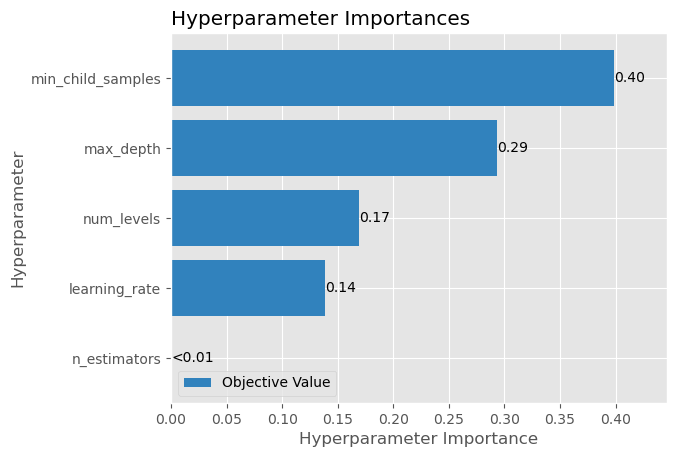

In [60]:
from optuna.visualization.matplotlib import plot_param_importances

plot_param_importances(study);

Обучим модель с лучшими параметрами

In [61]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

finish_test_preds = []
cv_predicts = np.empty(5)

for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
    model = lg.LGBMRegressor(objective="regression", **study.best_params,
                             verbose=-1, early_stopping_rounds=100)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric='rmsle')
        
    preds = model.predict(X_val)
    preds_exp = np.exp(preds) - 1
    y_val_exp = np.exp(y_val) - 1
    
    cv_predicts[idx] = rmsle(y_val_exp, preds_exp)
    preds_test = model.predict(X_test)
    finish_test_preds.append(preds_test)
    
    print(f'id={idx}', cv_predicts[idx], '\n')

print(np.mean(cv_predicts))

[LightGBM] [Warning] Unknown parameter: num_levels
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's l2: 0.480181
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.388832
[3]	valid_0's l2: 0.327806
[4]	valid_0's l2: 0.287102
[5]	valid_0's l2: 0.2597
[6]	valid_0's l2: 0.241322
[7]	valid_0's l2: 0.228817
[8]	valid_0's l2: 0.219559
[9]	valid_0's l2: 0.213059
[10]	valid_0's l2: 0.208502
[11]	valid_0's l2: 0.20513
[12]	valid_0's l2: 0.202762
[13]	valid_0's l2: 0.200731
[14]	valid_0's l2: 0.198384
[15]	valid_0's l2: 0.197182
[16]	valid_0's l2: 0.196224
[17]	valid_0's l2: 0.194913
[18]	valid_0's l2: 0.194023
[19]	valid_0's l2: 0.193186
[20]	valid_0's l2: 0.192172
[21]	valid_0's l2: 0.191567
[22]	valid_0's l2: 0.191126
[23]	valid_0's l2: 0.190706
[24]	valid_0's l2: 0.18997
[25]	valid_0's l2: 0.189653
[26]	valid_0's l2: 0.189359
[27]	valid_0's l2: 0.189126
[28]	va

[285]	valid_0's l2: 0.181501
[286]	valid_0's l2: 0.181501
[287]	valid_0's l2: 0.181497
[288]	valid_0's l2: 0.181498
[289]	valid_0's l2: 0.181494
[290]	valid_0's l2: 0.181491
[291]	valid_0's l2: 0.181491
[292]	valid_0's l2: 0.181482
[293]	valid_0's l2: 0.181485
[294]	valid_0's l2: 0.181483
[295]	valid_0's l2: 0.181513
[296]	valid_0's l2: 0.181503
[297]	valid_0's l2: 0.181505
[298]	valid_0's l2: 0.181508
[299]	valid_0's l2: 0.181504
[300]	valid_0's l2: 0.181506
[301]	valid_0's l2: 0.181508
[302]	valid_0's l2: 0.181501
[303]	valid_0's l2: 0.181499
[304]	valid_0's l2: 0.181497
[305]	valid_0's l2: 0.181494
[306]	valid_0's l2: 0.181493
[307]	valid_0's l2: 0.181493
[308]	valid_0's l2: 0.181497
[309]	valid_0's l2: 0.181499
[310]	valid_0's l2: 0.181495
[311]	valid_0's l2: 0.18149
[312]	valid_0's l2: 0.181487
[313]	valid_0's l2: 0.181477
[314]	valid_0's l2: 0.181486
[315]	valid_0's l2: 0.181497
[316]	valid_0's l2: 0.181493
[317]	valid_0's l2: 0.181492
[318]	valid_0's l2: 0.181495
[319]	valid_0's

[208]	valid_0's l2: 0.181909
[209]	valid_0's l2: 0.181908
[210]	valid_0's l2: 0.181905
[211]	valid_0's l2: 0.181898
[212]	valid_0's l2: 0.181886
[213]	valid_0's l2: 0.181876
[214]	valid_0's l2: 0.181865
[215]	valid_0's l2: 0.181864
[216]	valid_0's l2: 0.181853
[217]	valid_0's l2: 0.181843
[218]	valid_0's l2: 0.181828
[219]	valid_0's l2: 0.181829
[220]	valid_0's l2: 0.181819
[221]	valid_0's l2: 0.181816
[222]	valid_0's l2: 0.181817
[223]	valid_0's l2: 0.181795
[224]	valid_0's l2: 0.181795
[225]	valid_0's l2: 0.181812
[226]	valid_0's l2: 0.181815
[227]	valid_0's l2: 0.181809
[228]	valid_0's l2: 0.181809
[229]	valid_0's l2: 0.181803
[230]	valid_0's l2: 0.1818
[231]	valid_0's l2: 0.18181
[232]	valid_0's l2: 0.181807
[233]	valid_0's l2: 0.1818
[234]	valid_0's l2: 0.181797
[235]	valid_0's l2: 0.181776
[236]	valid_0's l2: 0.181775
[237]	valid_0's l2: 0.181764
[238]	valid_0's l2: 0.181761
[239]	valid_0's l2: 0.181757
[240]	valid_0's l2: 0.18176
[241]	valid_0's l2: 0.181766
[242]	valid_0's l2: 

[85]	valid_0's l2: 0.177035
[86]	valid_0's l2: 0.176976
[87]	valid_0's l2: 0.176926
[88]	valid_0's l2: 0.176914
[89]	valid_0's l2: 0.176885
[90]	valid_0's l2: 0.176796
[91]	valid_0's l2: 0.176744
[92]	valid_0's l2: 0.176684
[93]	valid_0's l2: 0.17668
[94]	valid_0's l2: 0.176678
[95]	valid_0's l2: 0.176655
[96]	valid_0's l2: 0.176648
[97]	valid_0's l2: 0.176641
[98]	valid_0's l2: 0.176608
[99]	valid_0's l2: 0.176591
[100]	valid_0's l2: 0.176545
[101]	valid_0's l2: 0.176504
[102]	valid_0's l2: 0.176489
[103]	valid_0's l2: 0.176428
[104]	valid_0's l2: 0.17639
[105]	valid_0's l2: 0.176364
[106]	valid_0's l2: 0.176401
[107]	valid_0's l2: 0.176382
[108]	valid_0's l2: 0.176374
[109]	valid_0's l2: 0.176365
[110]	valid_0's l2: 0.176313
[111]	valid_0's l2: 0.176309
[112]	valid_0's l2: 0.176279
[113]	valid_0's l2: 0.176255
[114]	valid_0's l2: 0.17621
[115]	valid_0's l2: 0.176217
[116]	valid_0's l2: 0.176199
[117]	valid_0's l2: 0.176194
[118]	valid_0's l2: 0.176163
[119]	valid_0's l2: 0.176158
[12

[377]	valid_0's l2: 0.175493
[378]	valid_0's l2: 0.175496
[379]	valid_0's l2: 0.175503
[380]	valid_0's l2: 0.175516
[381]	valid_0's l2: 0.175516
[382]	valid_0's l2: 0.175498
[383]	valid_0's l2: 0.175508
[384]	valid_0's l2: 0.175507
[385]	valid_0's l2: 0.175516
[386]	valid_0's l2: 0.175512
[387]	valid_0's l2: 0.175504
[388]	valid_0's l2: 0.175501
[389]	valid_0's l2: 0.175502
[390]	valid_0's l2: 0.175497
[391]	valid_0's l2: 0.175492
[392]	valid_0's l2: 0.175505
[393]	valid_0's l2: 0.175499
[394]	valid_0's l2: 0.175501
[395]	valid_0's l2: 0.175494
[396]	valid_0's l2: 0.175501
[397]	valid_0's l2: 0.175499
[398]	valid_0's l2: 0.175488
[399]	valid_0's l2: 0.175493
[400]	valid_0's l2: 0.175487
[401]	valid_0's l2: 0.175488
[402]	valid_0's l2: 0.175491
[403]	valid_0's l2: 0.175491
[404]	valid_0's l2: 0.175492
[405]	valid_0's l2: 0.17549
[406]	valid_0's l2: 0.175494
[407]	valid_0's l2: 0.175492
[408]	valid_0's l2: 0.175494
[409]	valid_0's l2: 0.175489
[410]	valid_0's l2: 0.175501
[411]	valid_0's

[222]	valid_0's l2: 0.175282
[223]	valid_0's l2: 0.175286
[224]	valid_0's l2: 0.175288
[225]	valid_0's l2: 0.175284
[226]	valid_0's l2: 0.175267
[227]	valid_0's l2: 0.175262
[228]	valid_0's l2: 0.175262
[229]	valid_0's l2: 0.175263
[230]	valid_0's l2: 0.175259
[231]	valid_0's l2: 0.175253
[232]	valid_0's l2: 0.175253
[233]	valid_0's l2: 0.175254
[234]	valid_0's l2: 0.175255
[235]	valid_0's l2: 0.175256
[236]	valid_0's l2: 0.175262
[237]	valid_0's l2: 0.175264
[238]	valid_0's l2: 0.175268
[239]	valid_0's l2: 0.175269
[240]	valid_0's l2: 0.175267
[241]	valid_0's l2: 0.17525
[242]	valid_0's l2: 0.175253
[243]	valid_0's l2: 0.175247
[244]	valid_0's l2: 0.17524
[245]	valid_0's l2: 0.175225
[246]	valid_0's l2: 0.175229
[247]	valid_0's l2: 0.17522
[248]	valid_0's l2: 0.175212
[249]	valid_0's l2: 0.175221
[250]	valid_0's l2: 0.175223
[251]	valid_0's l2: 0.175223
[252]	valid_0's l2: 0.175232
[253]	valid_0's l2: 0.175227
[254]	valid_0's l2: 0.175231
[255]	valid_0's l2: 0.175219
[256]	valid_0's l

[154]	valid_0's l2: 0.178845
[155]	valid_0's l2: 0.178837
[156]	valid_0's l2: 0.178815
[157]	valid_0's l2: 0.178786
[158]	valid_0's l2: 0.178763
[159]	valid_0's l2: 0.178758
[160]	valid_0's l2: 0.178748
[161]	valid_0's l2: 0.178736
[162]	valid_0's l2: 0.178729
[163]	valid_0's l2: 0.178719
[164]	valid_0's l2: 0.178728
[165]	valid_0's l2: 0.17872
[166]	valid_0's l2: 0.178724
[167]	valid_0's l2: 0.178718
[168]	valid_0's l2: 0.178711
[169]	valid_0's l2: 0.178707
[170]	valid_0's l2: 0.178673
[171]	valid_0's l2: 0.178666
[172]	valid_0's l2: 0.178661
[173]	valid_0's l2: 0.178669
[174]	valid_0's l2: 0.178662
[175]	valid_0's l2: 0.178659
[176]	valid_0's l2: 0.178654
[177]	valid_0's l2: 0.178653
[178]	valid_0's l2: 0.17866
[179]	valid_0's l2: 0.178662
[180]	valid_0's l2: 0.178662
[181]	valid_0's l2: 0.178657
[182]	valid_0's l2: 0.17866
[183]	valid_0's l2: 0.178645
[184]	valid_0's l2: 0.178645
[185]	valid_0's l2: 0.178643
[186]	valid_0's l2: 0.178641
[187]	valid_0's l2: 0.178622
[188]	valid_0's l

Ранее данные были прологарифмированы, выполню обратное преобразование

In [62]:
test_pred = np.mean(np.column_stack(finish_test_preds), axis=1)
test_pred_exp = np.exp(test_pred.data) - 1

y_test_exp = np.exp(y_test.values) - 1

In [63]:
print(f'OOF score: {np.mean(cv_predicts)}')
print(f'HOLDOUT score: {rmsle(y_test_exp, test_pred_exp)}')

OOF score: 0.4224064072134782
HOLDOUT score: 0.4187871241687811


## 3.2 LAMA    AutoML

In [64]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import torch
torch.set_num_threads(N_THREADS)

In [65]:
drop_cols_auto = [
    'id',
    'pickup_datetime',
    'dropoff_datetime',
    
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    
    'distance_geo',
    
    'date',
    
    'log_total_distance',
    'total_distance_km',
    'log_total_distance_km',
    
    'trip_duration_hour',
    'trip_duration',
    'log_trip_duration_hour',
    
    'speed_km_h',
    'log_speed_km_h',
]

Разбиваем данные на тренировочные и тестовые данные, не разбиваем на X, y. 

In [66]:
tr_data, te_data = train_test_split(df_all, 
                                   test_size=TEST_SIZE,
                                   random_state=RANDOM_STATE)
print('Data splitted, Parts sizes: tr_data = {}, te_data = {}'.format(
    tr_data.shape, te_data.shape))

Data splitted, Parts sizes: tr_data = (1089426, 37), te_data = (363142, 37)


Task - класс, при помощи него ставим задачу, которую необходимо решить (классиф, регрессия), а также какие метрики использовать

roles - роли, какая колонка отвечает за таргет (обязательно), какие нужно удалить и др. параметры

TabularAutoML - класс, структура общей модели

In [67]:
%%time

task = Task('reg', loss='rmsle', metric='rmsle')

Wall time: 971 µs


In [68]:
%%time

roles = {
    'target': 'log_trip_duration',
    'drop': drop_cols_auto
}

Wall time: 0 ns


In [83]:
automl = TabularAutoML(task = task,
                      timeout = TIMEOUT, 
                      cpu_limit = N_THREADS,
                      reader_params = {
                          'n_jobs': N_THREADS,
                          'cv': N_FOLDS,
                          'random_state': RANDOM_STATE,
                          'verbose': 1,
                      })

In [84]:
%%time

# out-of-fold prediction
oof_pred = automl.fit_predict(tr_data, roles = roles,  verbose = 1)

[16:37:50] Stdout logging level is INFO.
[16:37:50] Task: reg

[16:37:50] Start automl preset with listed constraints:
[16:37:50] - time: 600.00 seconds
[16:37:50] - CPU: 10 cores
[16:37:50] - memory: 16 GB

[16:37:50] Train data shape: (1089426, 37)

[16:38:01] Layer 1 train process start. Time left 588.41 secs
[16:38:02] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:38:15] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.0719010207825517
[16:38:15] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:38:15] Time left 574.78 secs

[16:38:30] Selector_LightGBM fitting and predicting completed
[16:38:31] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:39:15] Time limit exceeded after calculating fold 2

[16:39:15] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.05968608695016126
[16:39:15] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:39:15] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1

Посмртрим на стуктуру модели

In [85]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.79012 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.08549 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.12440 * (1 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 


In [86]:
oof_pred_exp = np.exp(oof_pred.data[:, 0]) - 1

test_pred = automl.predict(te_data)
test_pred_exp = np.exp(test_pred.data[:, 0]) - 1

In [90]:
print('OOF score:', rmsle(tr_data['trip_duration'], oof_pred_exp))
print('HOLDOUT score:', rmsle(te_data['trip_duration'].values, test_pred_exp))

OOF score: 0.42406449603516444
HOLDOUT score: 0.42035932542153537


# Feature importance

## 4.1 LGB + Optuna

In [92]:
from sklearn.inspection import permutation_importance

In [93]:
r = permutation_importance(model, X_test, y_test, n_repeats=5)

In [94]:
perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()), index=('Score', 'Features'))
perm_df = perm_df.T
perm_df = perm_df.sort_values(ascending=False, by='Score')

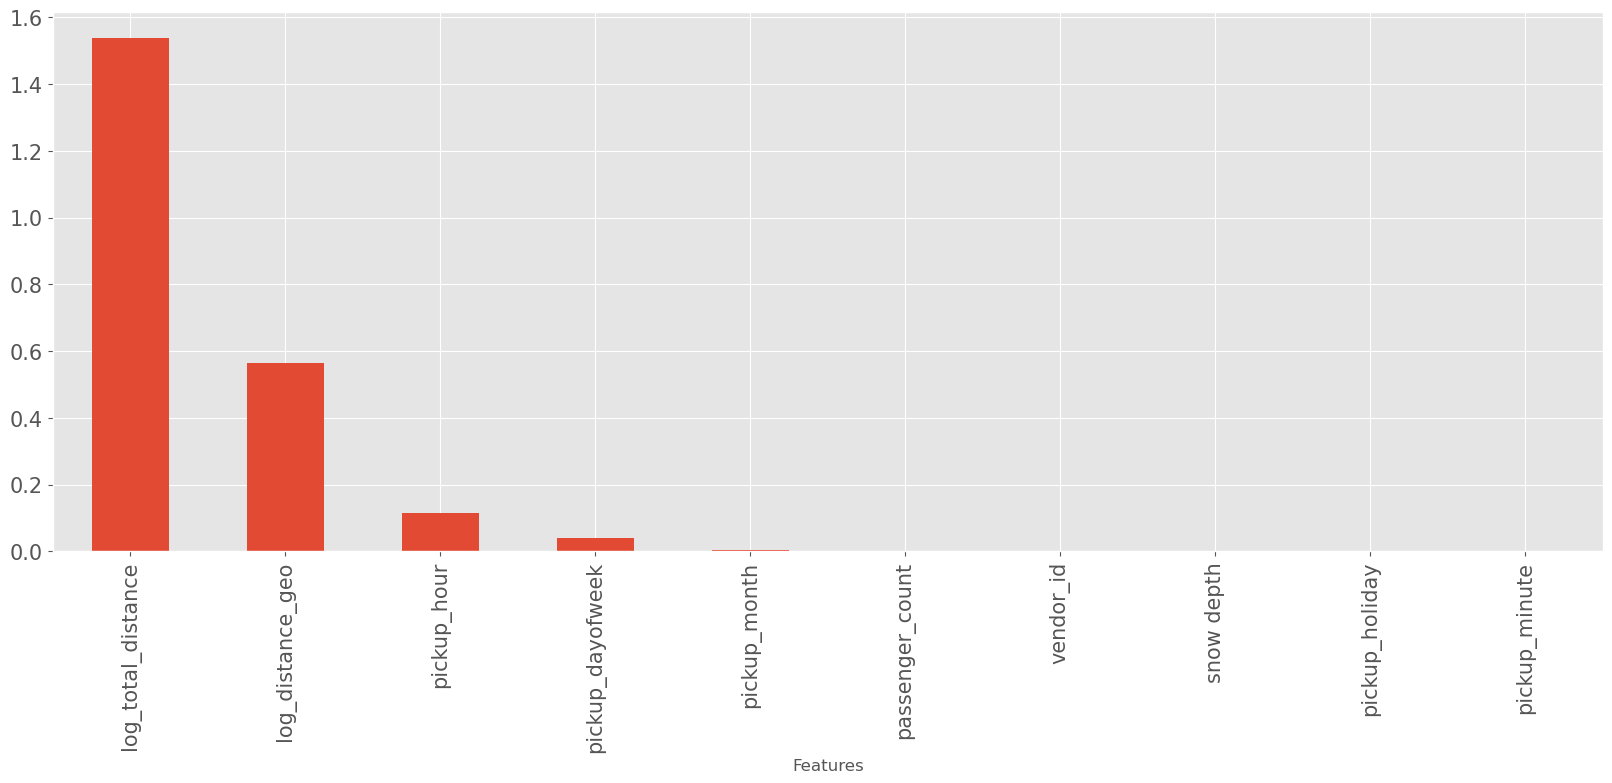

In [95]:
perm_df[:10].set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();

## 4.2 LAMA AutoML

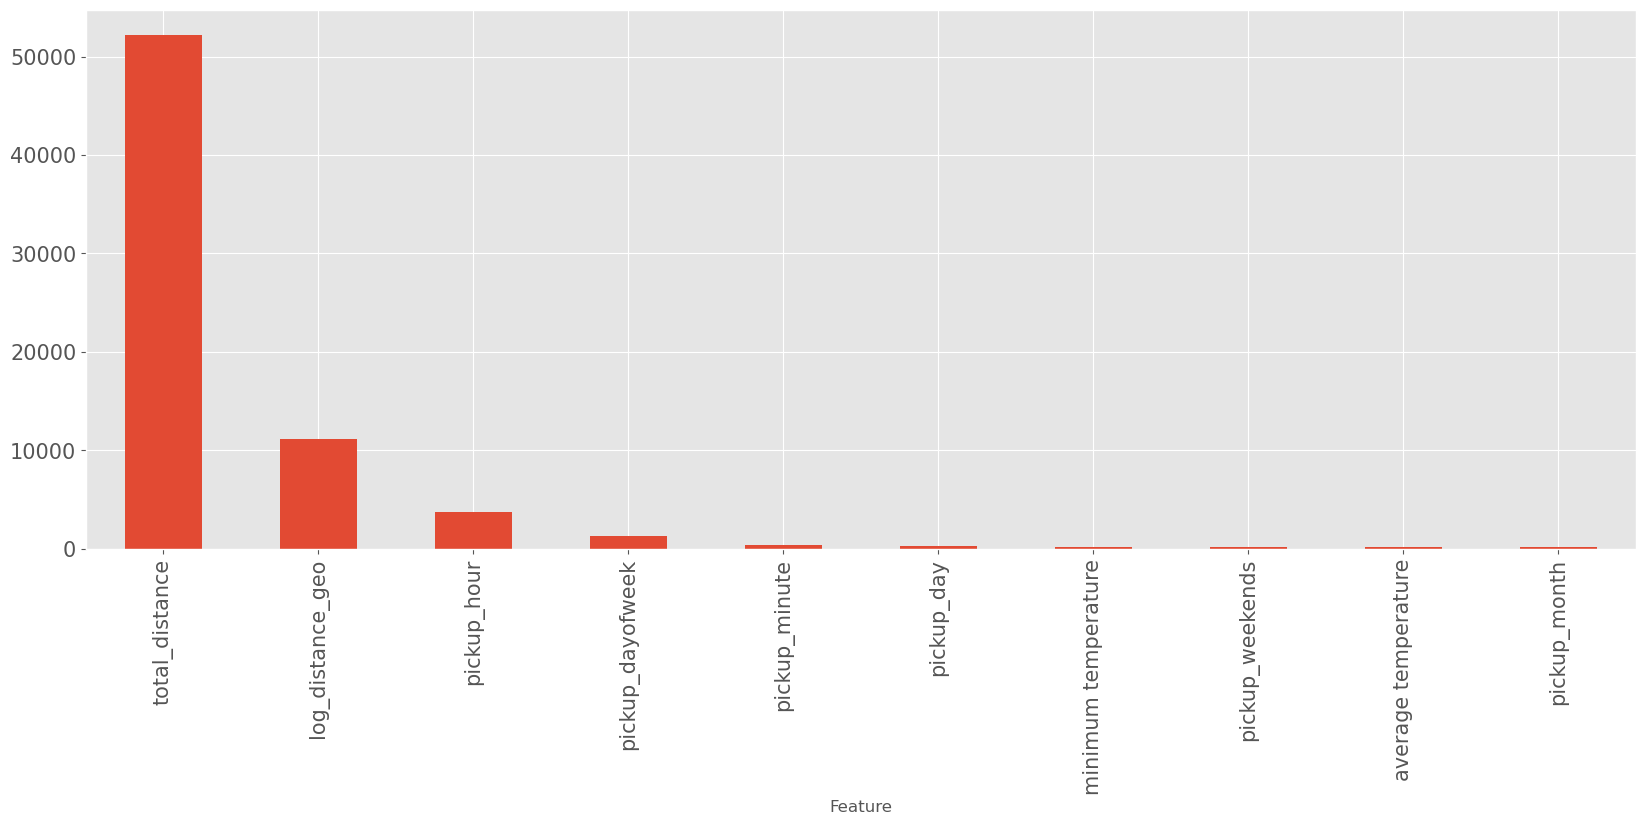

In [96]:
fast_fi = automl.get_feature_scores('fast')
fast_fi[:10].set_index('Feature')['Importance'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();